## Background
In this homework we will extract interesting information from [www.topuniversities.com](https://www.topuniversities.com) and [www.timeshighereducation.com](https://www.timeshighereducation.com), two platforms that maintain a global ranking of worldwide universities. This ranking is not offered as a downloadable dataset, so you will have to find a way to scrape the information we need! You are not allowed to download manually the entire ranking -- rather you have to understand how the server loads it in your browser. For this task, Postman with the Interceptor extension can help you greatly. We recommend that you watch this brief tutorial to understand quickly how to use it.

In [117]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import json
import numpy as np
import re
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import numbers

sns.set_context('notebook')
%matplotlib inline
mpl.rcParams['figure.figsize'] = (15,5)
mpl.rcParams['figure.dpi'] = 100

In [118]:
# Import libraries in order to create world maps (see end of the notebook)

# import shapefile
# import matplotlib.patches as patches
# from matplotlib.patches import Polygon
# from matplotlib.collections import PatchCollection
# import cartopy.crs as ccrs
# import cartopy.io.shapereader as shpreader
# import matplotlib.patches as mpatches

# Table of Contents

1. [Question 1 : Top Universities Ranking](#Q1)
    <br>
    1.1 [Ranking Scrapping](#Q1RS)
    <br>
    1.2 [Data Exploratory Analysis](#Q1DEA)
    <br>
      1.2.1 [Distribution](#Q1DEAD)
      <br>
      1.2.2 [Top Universities by Attributes](#Q1TOPU)
      <br>
      1.2.3 [Study by Region](#Q1SR)
      <br>
      1.2.4 [Study by Country](#Q1SC)
      <br>
      1.2.5 [Data Correlation](#Q1DC)
      <br>      
2. [Question 2 : Times Higher Education Ranking](#Q2)
    <br>
    2.1 [Ranking Scrapping](#Q2RS)
    <br>
    2.2 [Data Exploratory Analysis](#Q2DEA)
    <br>
      2.2.1 [Distribution](#Q2DEAD)
      <br>
      2.2.2 [Top Universities by Attributes](#Q2TOPU)
      <br>
      2.2.3 [Study by Country](#Q2SC)
      <br>
      2.2.4 [Data Correlation](#Q2DC)
      <br>
3. [Question 3 : Merging of the dataframe](#Q3)
    <br>
    3.1 [Name Matching](#Q3NM)
    <br>
    3.2 [Region Matching](#Q3RM)
    <br>
    3.3 [Merging](#Q3MERGE)
    <br>
4. [Question 4 : Exploratory Data Analysis](#Q4)
    <br>
    4.1 [Preprocessing : Merging Similar Columns](#Q4PREP)
    <br>
    4.2 [Adding Population by Country](#Q4POP)
    <br>
    4.3 [Data Correlation](#Q4DC)
    <br>
5. [Question 5 : New Ranking](#Q5)
<br>
6. [Extra : World Map Visualization](#EXTRA)

# Assignement

<a id = "Q1"></a>
# Question 1. 
Obtain the 200 top-ranking universities in www.topuniversities.com (ranking 2018). In particular, extract the following fields for each university: name, rank, country and region, number of faculty members (international and total) and number of students (international and total). Some information is not available in the main list and you have to find them in the details page. Store the resulting dataset in a pandas DataFrame and answer the following questions:


* Which are the best universities in term of: (a) ratio between faculty members and students, (b) ratio of international students?
* Answer the previous question aggregating the data by (c) country and (d) region.

Plot your data using bar charts and describe briefly what you observed.

### Answer

<a id = "Q1RS"></a>
# Rankings from the www.topuniversities.com website

While accessing the data in a browser, we notice when using `postman interceptor` that quantities of interest are stored in a seperated .txt file. We can directly access the .txt file through its url. To get extra information about the universities, we read urls in the .txt file leading to university specific webpage containing additional data. We then make requests on these urls to acces the information.

In [119]:
url = 'https://www.topuniversities.com'
Url =  'https://www.topuniversities.com/sites/default/files/qs-rankings-data/357051_indicators.txt'

In [120]:
#We create a request with our url
r = requests.get(Url,
                 auth=('user', 'pass'))

In [121]:
#We set a variable to control the number of universities we want in our top.
top = 200

#We create the wrapper at json format
wrapper = r.json()

#We take the first 'top' universities 
university_wrapper = wrapper['data'][:top]

In [122]:
#We define the 'stats' function which take a link/url as input and return the number of students (total/international) and 
# staff (total/international)
def stats(link):
    
    #We make a request with the url and then parse it with BeautifulSoup
    r = requests.get(link)
    soup = BeautifulSoup(r.text,'lxml')
    
    #At each step, we try to get the desired value and in case of trouble we set the value at NaN
    try:
        
        nb_st = int(soup.find('div',{'class' : 'total student'}).find('div', {'class': 'number'}).text[1:].replace(',',''))
    
    except:
        
        nb_st = np.NaN
        
    try:
        
        nb_inter_st = int(soup.find('div',{'class' : 'total inter'}).find('div', {'class': 'number'}).text[1:].replace(',',''))
        
    except:
        
        nb_inter_st = np.NaN
        
    try:
        
        total_staff = [p.find('div', 'number').text for p in soup.find_all('div', 'total faculty',limit =1)]
        ## Convert the # staff number to a float (original string ('\n2,982'))
        total_staff = int(re.findall('\d+(?:,\d+)?',str(total_staff))[0].replace(',',''))
        
    except:
        
        total_staff = np.NaN

    try:
        
        ## Find the number of international staff by navigating through the class, limit = 1 because it is given 2 times
        ## list comprehension is necessary to use the iterator returned by soup.find_all()
        international_staff = [p.find('div', 'number').text for p in soup.find_all('div', 'inter faculty',limit =1)]
        ## Convert the international staff number to a float using regex (original string ('\n1,679'))
        international_staff = int(re.findall('\d+(?:,\d+)?',str(international_staff))[0].replace(',',''))
        
    except: 
        
        international_staff = np.NaN
        
    stats = (nb_st,nb_inter_st,international_staff,total_staff)
    
    return stats

In [123]:
#We create differents variables which of them will then be usefull to create the dataframe,
names = [BeautifulSoup(uni['uni'], 'lxml').text for uni in university_wrapper]

#To avoid hypothetical conflicts whithin the ranks, we set the ranks with a list from 1 to 199
ranks = np.arange(1,top+1)

countries = [BeautifulSoup(uni['location'], 'lxml').text for uni in university_wrapper]
regions = [BeautifulSoup(uni['region'], 'lxml').text for uni in university_wrapper]

#We get all internal url which of them leads us to some extra information about the universities and will then
#be the input of our 'stats' function
links = [BeautifulSoup(uni['uni'], 'lxml').find_all('a',href = True)[0]['href'] for uni in university_wrapper]
links = [url+l for l in links]

In [124]:
# If the data frame has already been created and saved to the current folder, read it
# This is to save bandwith and time when querying 200 urls.
try:
    qs_df = pd.read_pickle('ranking_QS_TopUni_DF')
# Otherwise, we create the dataframe
except:
    #We associate at each url(one per uni) the corresponding statistics, and we use the map function to do that in a concis way.
    statistics = list(map(stats,links))

    #We get the corresponding stats
    nb_std = [x[:][0] for x in statistics]
    nb_inter_std = [x[:][1] for x in statistics]
    international_staff = [x[:][2] for x in statistics]
    total_staff = [x[:][3] for x in statistics]

    qs_df = pd.DataFrame({'Name' : names,
                          'Rank' : ranks,
                          'Country' : countries,
                          'Region' : regions,
                          '# Students' : nb_std,
                          '# international students' : nb_inter_std,
                          '# international staff' : international_staff,
                          '# staff' : total_staff})

    qs_df = qs_df[['Rank','Name','# Students','# international students',
                   '# international staff','# staff','Country','Region']]
    
    qs_df['Rank'] = qs_df['Rank'].astype(int)
    qs_df.to_pickle('ranking_QS_TopUni_DF')

We compute interesting quantities like the ratio of international students or staff and the percentage of university staff member per student :

In [125]:
qs_df['% staff per student'] = (qs_df['# staff'] / qs_df['# Students'])*100.0
qs_df['% of international students'] = (qs_df['# international students'] / qs_df['# Students'])*100.0
qs_df['% of international staff'] = (qs_df['# international staff'] / qs_df['# staff'])*100.0

Let's have a look at the dataframe :

In [126]:
qs_df.head()

,Rank,Name,# Students,# international students,# international staff,# staff,Country,Region,% staff per student,% of international students,% of international staff
0,1,Massachusetts Institute of Technology (MIT),11067.0,3717.0,1679.0,2982.0,United States,North America,26.944972,33.586338,56.304494
1,2,Stanford University,15878.0,3611.0,2042.0,4285.0,United States,North America,26.987026,22.742159,47.654609
2,3,Harvard University,22429.0,5266.0,1311.0,4350.0,United States,North America,19.394534,23.478532,30.137931
3,4,California Institute of Technology (Caltech),2255.0,647.0,350.0,953.0,United States,North America,42.261641,28.691796,36.726128
4,5,University of Cambridge,18770.0,6699.0,2278.0,5490.0,United Kingdom,Europe,29.248801,35.689931,41.493625


<a id = "Q1DEA"></a>
# Data exploratory analysis

## Statistics of the data

The `describe` method allows to get an overview of the data.

In [127]:
qs_df.describe()

,Rank,# Students,# international students,# international staff,# staff,% staff per student,% of international students,% of international staff
count,200.000000,199.000000,199.000000,198.000000,199.000000,199.000000,199.000000,198.000000
mean,100.500000,25684.914573,5092.306533,789.146465,2926.301508,12.638762,21.120504,28.449685
std,57.879185,17120.293455,3919.062605,665.080190,2015.173740,6.027615,11.618931,17.074585
min,1.000000,532.000000,47.000000,1.000000,86.000000,4.039133,0.989151,0.840336
25%,50.750000,15140.500000,2637.500000,336.750000,1636.500000,8.481900,12.454452,14.724295
50%,100.500000,23775.000000,4311.000000,609.500000,2645.000000,11.553030,19.416825,27.598522
75%,150.250000,32216.000000,6880.500000,1027.750000,3648.000000,14.853606,28.023664,38.611577
max,200.000000,141939.000000,27109.000000,3905.000000,16421.000000,42.261641,69.139344,76.696165


We notice that the attributes contain strong outliers : for instance the standard deviation of number of students is more than half of the second quartile of the distribution.

The dataframe contains universities for which we do not have a value for every attributes (ie 199 values of students number where 200 universities have been querried). This is due to the fact that some data are missing on the webpages of some universities (for instance : [New York University page without data](https://www.topuniversities.com/universities/new-york-university-nyu/new-york-university-nyu#wurs) )



<a id = "Q1DEAD"></a>
## Distributions

Unless specified otherwise, the error bars displayed on the graphs of this notebook are referring to the 95% confidence intervals.

We show the distribution of students among the universities

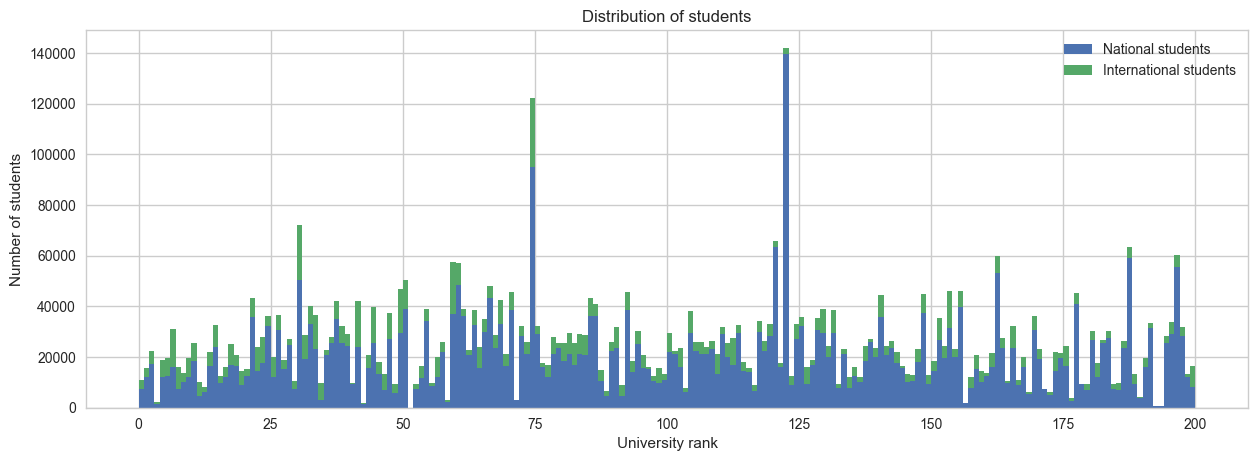

In [128]:
p1 = plt.bar(qs_df['Rank'], qs_df['# Students'] - qs_df['# international students'], -1, align='edge')
p2 = plt.bar(qs_df['Rank'], qs_df['# international students'], -1, align='edge',
             bottom=qs_df['# Students'] - qs_df['# international students'])

plt.ylabel('Number of students')
plt.xlabel('University rank')
plt.title('Distribution of students')
plt.legend((p1[0], p2[0]), ('National students', 'International students'))

plt.show()

In [129]:
# We see on the graphs that there are outliers in the distribution. Let's find them :
qs_df.loc[qs_df['# Students'] > 120000]

,Rank,Name,# Students,# international students,# international staff,# staff,Country,Region,% staff per student,% of international students,% of international staff
74,75,Universidad de Buenos Aires (UBA),122301.0,27109.0,3165.0,16421.0,Argentina,Latin America,13.426710,22.165804,19.274100
122,123,Universidad Nacional Autónoma de México (UNAM),141939.0,2173.0,949.0,15073.0,Mexico,Latin America,10.619351,1.530939,6.296026


We see that the number of students is quite high for the majority of the top 200 universities, with more than 23000 students for 50% of the ranking. We can also see some impressive outliers, the *Universidad de Buenos Aires (UBA)* with 122301 students and the *Universidad Nacional Autónoma de México (UNAM)* with 141939 students. 

The staff members seems to be correlated with the number of students as we can see on the following bar chart. More study on correlation will be done below.

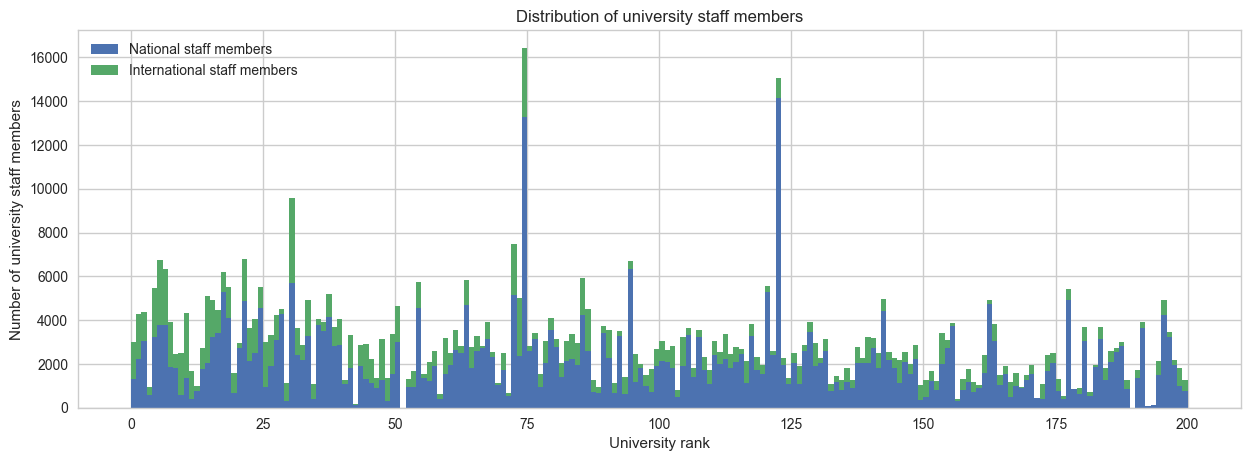

In [130]:
p1 = plt.bar(qs_df['Rank'], qs_df['# staff'] - qs_df['# international staff'], -1, align='edge')
p2 = plt.bar(qs_df['Rank'], qs_df['# international staff'], -1, align='edge',
             bottom=qs_df['# staff'] - qs_df['# international staff'])

plt.ylabel('Number of university staff members')
plt.xlabel('University rank')
plt.title('Distribution of university staff members')
plt.legend((p1[0], p2[0]), ('National staff members', 'International staff members'))

plt.show()

Since there are so much difference in absolute numbers between the universities, we will study normalized quantities such as the percentage of international student or staff

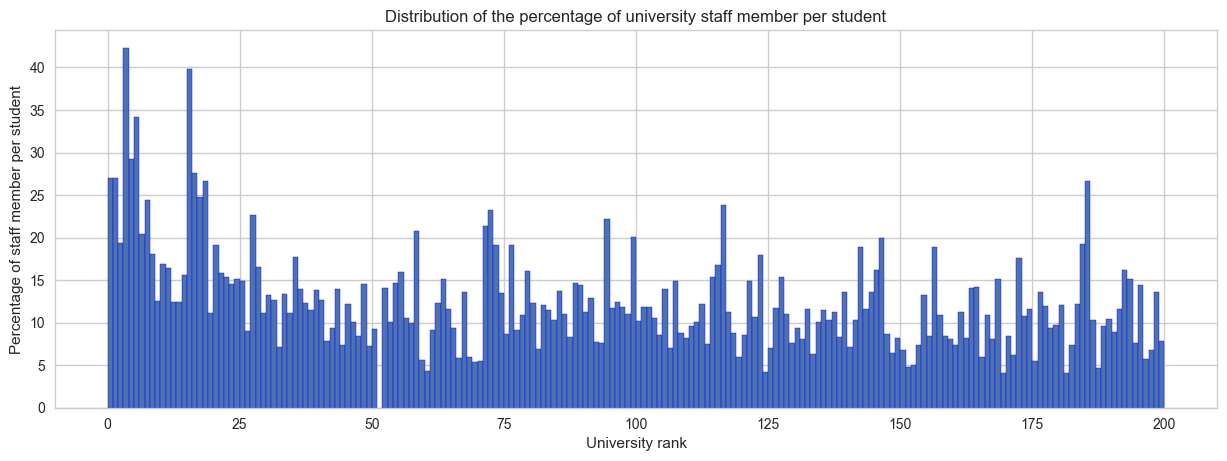

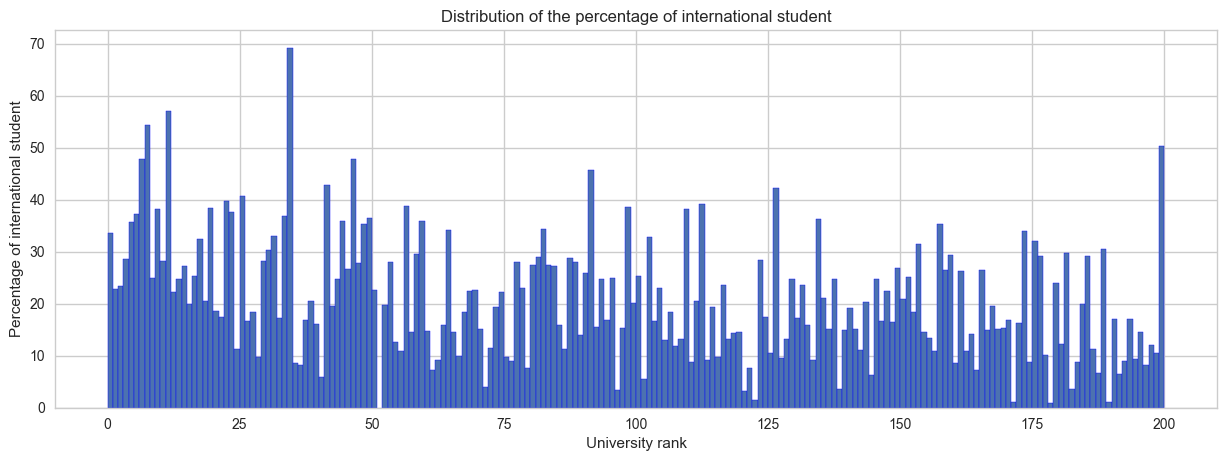

In [131]:
# We can group the universities by rank, making groups of sizes chunk_size
chunk_size = 1
# We group by rank, and extract the ratio of staff member per student, which is multiplied by 100 to have a percentage
temp_groupby = qs_df['% staff per student']\
                                    .groupby(lambda x: int(np.ceil(qs_df['Rank'].loc[x]/chunk_size)))
percentageStaffStudent = temp_groupby.mean()
# We extract the quantiles to draw the error bars
confInterLow = temp_groupby.quantile(0.025)
confInterUp  = temp_groupby.quantile(0.975)
    
# Create temporary dataframe for plotting
df_tmp = pd.DataFrame({'rank' : percentageStaffStudent.index*chunk_size, '% staff per student' : percentageStaffStudent})
# Plotting with seaborn
sns.set_style("whitegrid")
fig, ax = plt.subplots()
bars = plt.bar(df_tmp['rank'], df_tmp['% staff per student'],
               -chunk_size,
               yerr=[df_tmp['% staff per student'] - confInterLow, confInterUp - df_tmp['% staff per student']],
               align='edge', edgecolor = 'blue')

ax.set_xlabel(('University rank'), rotation=0)
ax.set_ylabel(('Percentage of staff member per student'))
ax.set_title('Distribution of the percentage of university staff member per student')
plt.show()


# We group by rank, and extract the percentage of international students among the students
temp_groupby = qs_df['% of international students'].groupby(lambda x: int(np.ceil(qs_df['Rank'].loc[x]/chunk_size)))
percentageInternationalStudent = temp_groupby.mean()
confInterLow = temp_groupby.quantile(0.025)
confInterUp  = temp_groupby.quantile(0.975)

# Create temporary dataframe for plotting
df_tmp = pd.DataFrame({'rank' : percentageInternationalStudent.index*chunk_size,
                       '% of international students' : percentageInternationalStudent})
# Plotting with seaborn
fig, ax = plt.subplots()
bars = plt.bar(df_tmp['rank'], df_tmp['% of international students'],
               -chunk_size,
               yerr=[df_tmp['% of international students'] - confInterLow,
                     confInterUp - df_tmp['% of international students']],
               align='edge', edgecolor = 'blue')
ax.set_xlabel(('University rank'), rotation=0)
ax.set_ylabel(('Percentage of international student'))
ax.set_title('Distribution of the percentage of international student')
plt.show()

#We delete the temporary dataframe as we do not use it later
del df_tmp

We clearly see on the first bar chart of the distribution of the percentage of university staff member per student that top universities (till rank 20) have a higher ratio staff/student than the rest of the ranking. The correlation between the ranking and the percentage of international student is less pronounced, but we will show later that it exists.

<a id = "Q1TOPU"></a>
## Top universities per attributes

The 5 best universities of this ranking in term of ratio between faculty members and students :

In [132]:
qs_df.sort_values('% staff per student', ascending=False)[['Name','% staff per student']].head()

,Name,% staff per student
3,California Institute of Technology (Caltech),42.261641
15,Yale University,39.832285
5,University of Oxford,34.229209
4,University of Cambridge,29.248801
16,Johns Hopkins University,27.635328


The 5 best universities of this ranking in term of ratio of international students :

In [133]:
qs_df.sort_values('% of international students', ascending=False)[['Name','% of international students']].head()

,Name,% of international students
34,London School of Economics and Political Scien...,69.139344
11,Ecole Polytechnique Fédérale de Lausanne (EPFL),57.004738
7,Imperial College London,54.356743
199,Maastricht University,50.253280
46,Carnegie Mellon University,47.806229


<a id = "Q1SR"></a>
## Study by Region

We then perform a similar study by comparing the region where the top universities are located : 

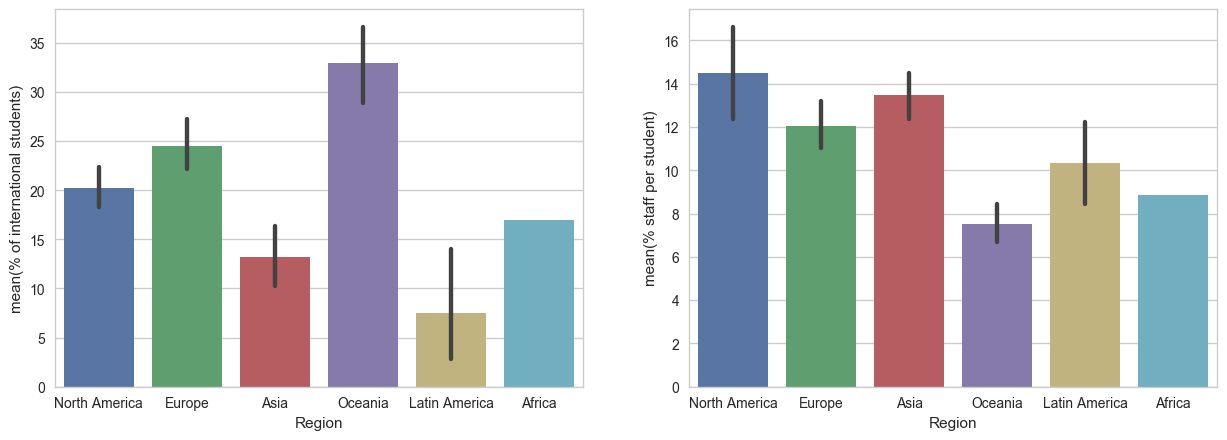

In [134]:
# Group by region
fig, (ax1, ax2) = plt.subplots(ncols=2)
ax = sns.barplot(x="Region", y="% of international students", data=qs_df, ax=ax1)
ax = sns.barplot(x="Region", y="% staff per student", data=qs_df, ax=ax2)
plt.show()
# There are no error bars for region that have only one university in the ranking

The percentage of international student is higher in the Oceania region follow by the Europe and North America regions. The ratios of staff per student are similar in the North America, Europe and Asia regions.

<a id = "Q1SC"></a>
## Study by Country

We then study the influence of the country on the attributes of our dataframe : 

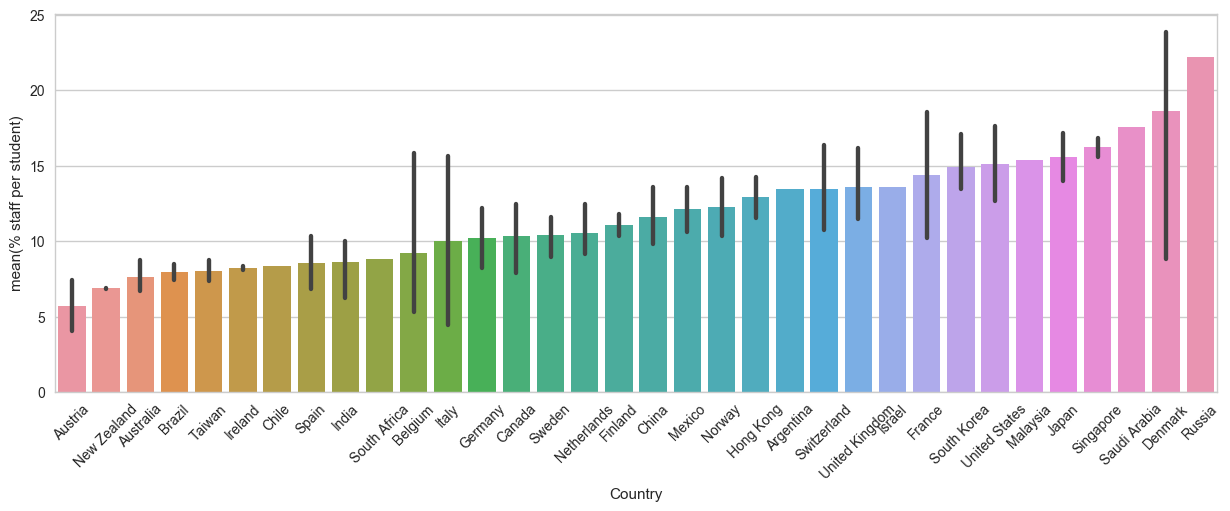

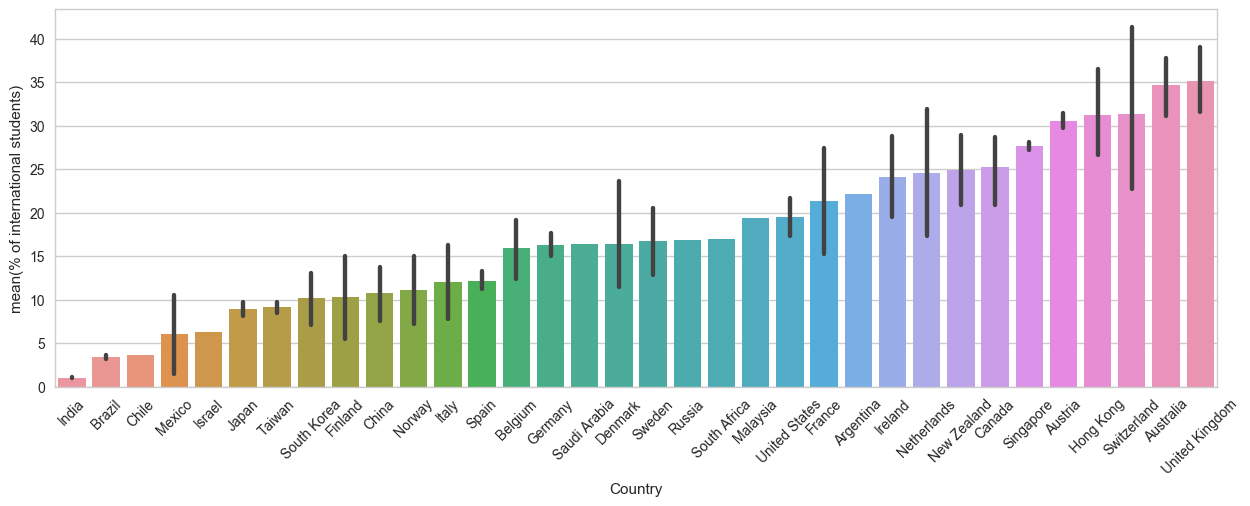

In [135]:
# Group by per country
# Percentage of staff member per student
# We create an order groupby object to sort the bar plot 
sortedGroupby = qs_df.groupby(["Country"])['% staff per student'].mean().reset_index().sort_values('% staff per student')
# plot
ax = sns.barplot(x="Country", y="% staff per student", data=qs_df, order = sortedGroupby['Country'])
plt.xticks(rotation = 45)
plt.show()

# Percentage of international students
# We create an order groupby object to sort the bar plot 
sortedGroupby = qs_df.groupby(["Country"])['% of international students'].mean()\
                        .reset_index().sort_values('% of international students')
# plot
ax = sns.barplot(x="Country", y="% of international students",
                 data=qs_df,
                 order = sortedGroupby['Country'])
plt.xticks(rotation = 45)
plt.show()

We see that the ratio staff per student is the highest in Russia, however as there is only one Russian's university in the top 200 of the ranking, we can not make any conclusion on the importance put on the number of academic staff in Russia. 

For the proportion of international students, we see higher values for 5 countries : The United Kingdom, Australia, Switzerland, Hong Kong, Austria. We will try to correlate this observation with the population of each country, see below.

<a id = "Q1DC"></a>
## Data Correlation

We want to find out if the rank of a university is correlated to the other attributes that we have. To do this we can plot these attributes with respect to the rank :

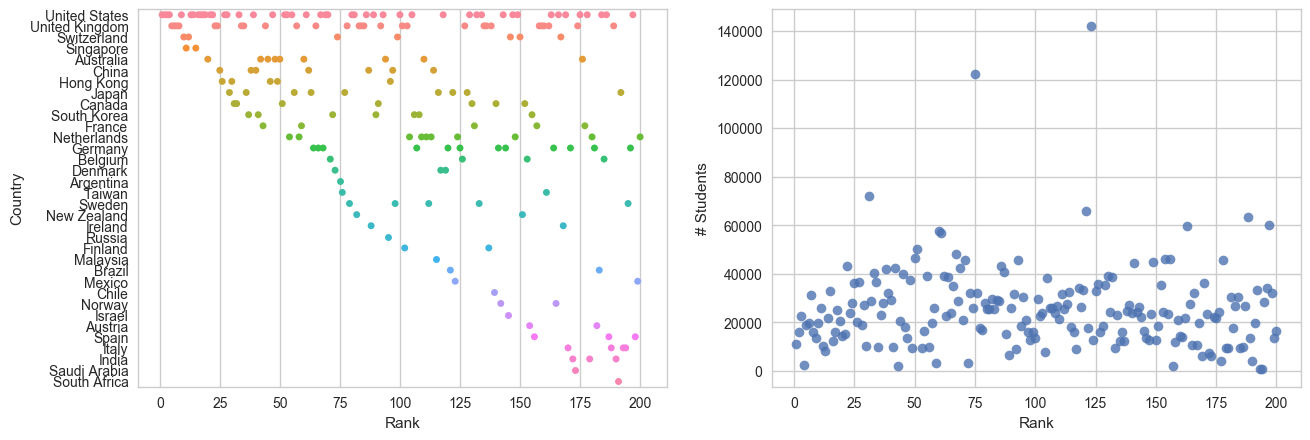

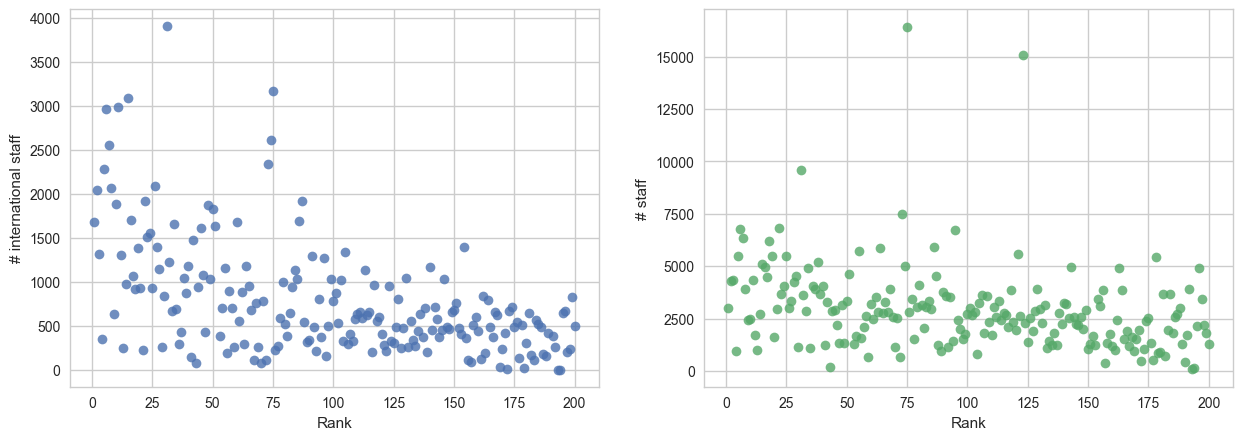

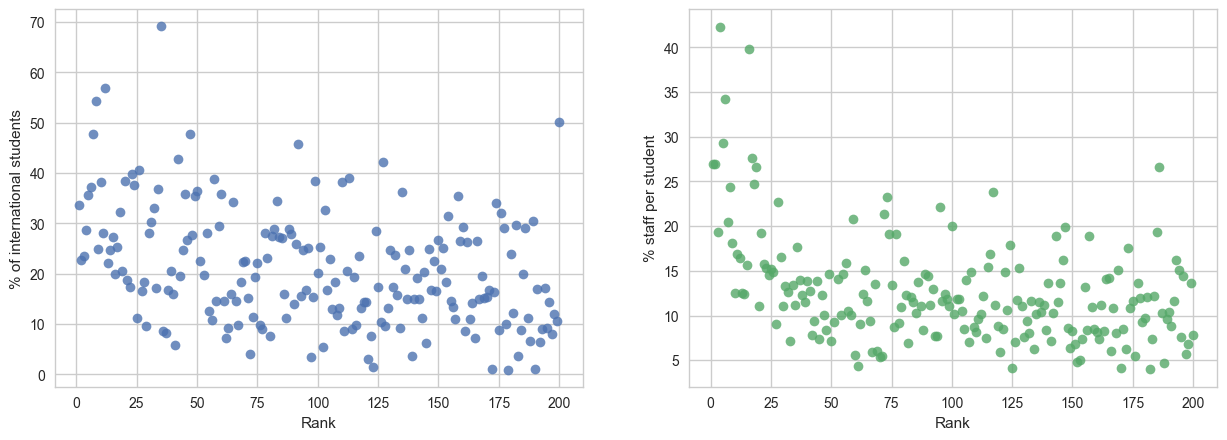

In [136]:
fig, (ax1, ax2) = plt.subplots(ncols=2)
qs_df.sort_values('Rank', inplace = True)
sns.stripplot(x="Rank", y="Country", data=qs_df, ax=ax1)
sns.regplot(x = 'Rank', y = '# Students', data=qs_df, fit_reg=False, ax=ax2)
plt.show()

fig, (ax1, ax2) = plt.subplots(ncols=2)
sns.regplot(x = 'Rank', y = '# international staff', data=qs_df, fit_reg=False, ax=ax1)
sns.regplot(x = 'Rank', y = '# staff', data=qs_df, fit_reg=False, ax=ax2)
plt.show()

fig, (ax1, ax2) = plt.subplots(ncols=2)
sns.regplot(x = 'Rank', y = '% of international students', data=qs_df, fit_reg=False, ax=ax1)
sns.regplot(x = 'Rank', y = '% staff per student', data=qs_df, fit_reg=False, ax=ax2)
plt.show()

- We notice that a lot of the top 200 universities are located in the USA.
- We can see that the number of students does not seem to be correlated with the rank. 
- As observed before, the percentage of staff per student seems to be correlated to the rank with the presence of higher values under the top 20 of the ranking. 
- A correlation can also be observed with the number of internatinal academica staff which seems to decrease when going lower in the ranking.
- Finally, the correlation between the rank and the percentage of international students is very low, there seems to be a higher percentage for the upper ranking but the decrease is not very pronounced.

<a id = "Q2"></a>
# Question 2. 
Obtain the 200 top-ranking universities in www.timeshighereducation.com (ranking 2018). Repeat the analysis of the previous point and discuss briefly what you observed.

### Answer :

<a id = "Q2RS"></a>
# Rankings from the www.timeshighereducation.com website

In [137]:
### This URL was obtained by using Postman interceptor on this URL : http://timeshighereducation.com/world-university-rankings/2018/world-ranking
### and getting the new URL which loads the JSON file which contains the ranking
URL_JSON_TIMES = 'https://www.timeshighereducation.com/sites/default/files/the_data_rankings/world_university_rankings_2018_limit0_369a9045a203e176392b9fb8f8c1cb2a.json'

r = requests.get(URL_JSON_TIMES)

data_times = json.loads(r.text)

In [138]:
## Initialize the list that will contain the ranking and some attributes to each university
rank = []
name = []
number_student = []
student_per_staff = []
country = []
number_international_students = []

## Iterate over all 200 first university
for i in range(200):
    rank.append(i+1) #Use the iterator to register the rank to get rid of ties in the ranking
    name.append(data_times["data"][i]["name"]) #Get the name of the university
    number_student.append(data_times["data"][i]["stats_number_students"]) #Get the number of students
    student_per_staff.append(data_times["data"][i]["stats_student_staff_ratio"]) #Get the ratio student/staff
    number_international_students.append(data_times["data"][i]["stats_pc_intl_students"]) #Get the number of inter students
    country.append(data_times["data"][i]["location"]) #Get the country of the university

## Creation of the datafram containing the rankings and information on the universities
times_ranking = pd.DataFrame(rank, columns = ["Rank"]) #Create a dataframe with the rank

##Add the different attributes
times_ranking['Name'] = name 
times_ranking['# Students'] = number_student 
times_ranking['Student per staff'] = student_per_staff
times_ranking['% of international students'] = number_international_students
times_ranking['Country'] = country

##Convert the numbers stored as string to numeric values (replace the comma and percentage sign, convert to float)
times_ranking['# Students'] = times_ranking['# Students'].str.replace(',', '')
times_ranking['Student per staff'] = times_ranking['Student per staff'].str.replace(',', '')
times_ranking['% of international students'] = times_ranking['% of international students'].str.replace('%', '')
times_ranking[["# Students", "Student per staff", "% of international students"]] =  \
    times_ranking[["# Students", "Student per staff", "% of international students"]].apply(pd.to_numeric)

times_ranking['% staff per student'] = np.reciprocal(times_ranking['Student per staff'])*100

<a id = "Q2DEA"></a>
# Data Exploratory Analysis

## Statistics of the data

We again use the `describe` method to get an overview of the data

In [139]:
times_ranking.describe()

,Rank,# Students,Student per staff,% of international students,% staff per student
count,200.000000,200.00000,200.000000,200.000000,200.000000
mean,100.500000,24746.29500,17.793000,21.865000,7.852749
std,57.879185,13353.01984,12.347931,11.565708,4.736113
min,1.000000,515.00000,3.300000,3.000000,1.283697
25%,50.750000,14880.25000,11.175000,13.000000,5.050888
50%,100.500000,23130.50000,14.550000,19.000000,6.872933
75%,150.250000,32933.25000,19.800000,28.000000,8.948681
max,200.000000,69427.00000,77.900000,71.000000,30.303030


As for the previous ranking, the distribution is spreaded out with strong outliers.

<a id = "Q2DEAD"></a>
## Distribution of the data

We visualize the attributes distributions with respect to the rank of the universities

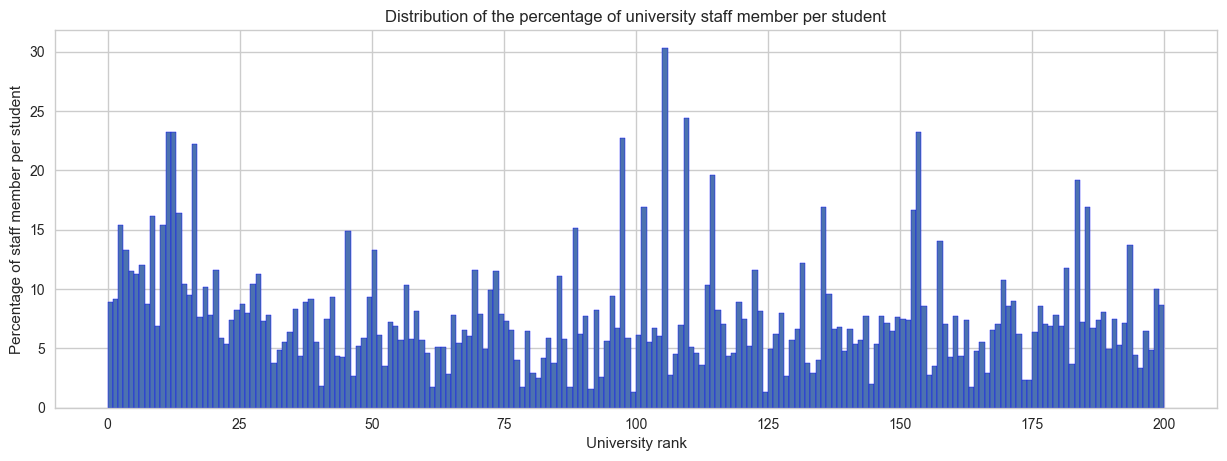

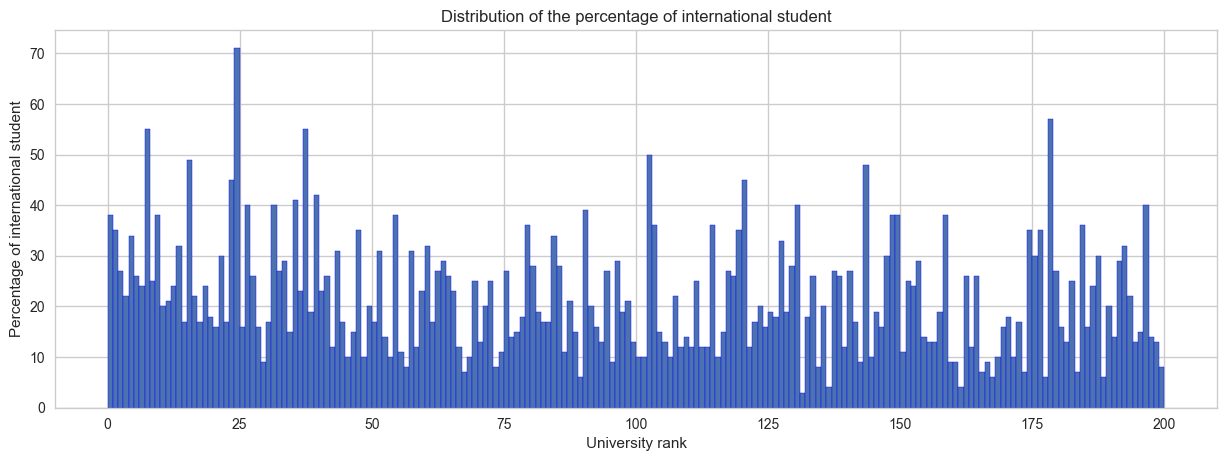

In [140]:
# We can group the universities by rank, making groups of sizes chunk_size
chunk_size = 1
# We group by rank, and extract the ratio of staff member per student, which is multiplied by 100 to have a percentage
temp_groupby = times_ranking['% staff per student']\
                                    .groupby(lambda x: int(np.ceil(qs_df['Rank'].loc[x]/chunk_size)))
percentageStaffStudent = temp_groupby.mean()
confInterLow = temp_groupby.quantile(0.025)
confInterUp  = temp_groupby.quantile(0.975)


# Create temporary dataframe for plotting
df_tmp = pd.DataFrame({'rank' : percentageStaffStudent.index*chunk_size, '% staff per student' : percentageStaffStudent})

sns.set_style("whitegrid")
fig, ax = plt.subplots()
bars = plt.bar(df_tmp['rank'], df_tmp['% staff per student'],
               -chunk_size,
               yerr=[df_tmp['% staff per student'] - confInterLow,
                     confInterUp - df_tmp['% staff per student']],
               align='edge', edgecolor = 'blue')
ax.set_xlabel(('University rank'), rotation=0)
ax.set_ylabel(('Percentage of staff member per student'))
ax.set_title('Distribution of the percentage of university staff member per student')
plt.show()



# We group by rank, and extract the percentage of international students among the students
temp_groupby = times_ranking['% of international students'] \
                                    .groupby(lambda x: int(np.ceil(qs_df['Rank'].loc[x]/chunk_size)))
percentageInternationalStudent = temp_groupby.mean()
confInterLow = temp_groupby.quantile(0.025)
confInterUp  = temp_groupby.quantile(0.975)

# Create temporary dataframe for plotting
df_tmp = pd.DataFrame({'rank' : percentageInternationalStudent.index*chunk_size,
                       '% of international students' : percentageInternationalStudent})
# Plotting with seaborn
fig, ax = plt.subplots()
bars = plt.bar(df_tmp['rank'], df_tmp['% of international students'],
               -chunk_size,
               yerr=[df_tmp['% of international students'] - confInterLow,
                     confInterUp - df_tmp['% of international students']],
               align='edge', edgecolor = 'blue')
ax.set_xlabel(('University rank'), rotation=0)
ax.set_ylabel(('Percentage of international student'))
ax.set_title('Distribution of the percentage of international student')
plt.show()

#We delete the temporary dataframe as we do not use it later
del df_tmp

<a id = "Q2TOPU"></a>
## Top universities per attributes

The 5 best universities in term of ratio between faculty members and students :

In [141]:
times_ranking.sort_values('% staff per student', ascending=False)[['Name','% staff per student']].head()

,Name,% staff per student
105,Vanderbilt University,30.303030
109,University of Copenhagen,24.390244
153,University of Rochester,23.255814
11,Yale University,23.255814
12,Johns Hopkins University,23.255814


The 5 best universities in term of ratio of international students :

In [142]:
times_ranking.sort_values('% of international students', ascending=False)[['Name','% of international students']].head()

,Name,% of international students
24,London School of Economics and Political Science,71
178,University of Luxembourg,57
37,École Polytechnique Fédérale de Lausanne,55
7,Imperial College London,55
102,Maastricht University,50


<a id = "Q2SC"></a>
## Study by Country

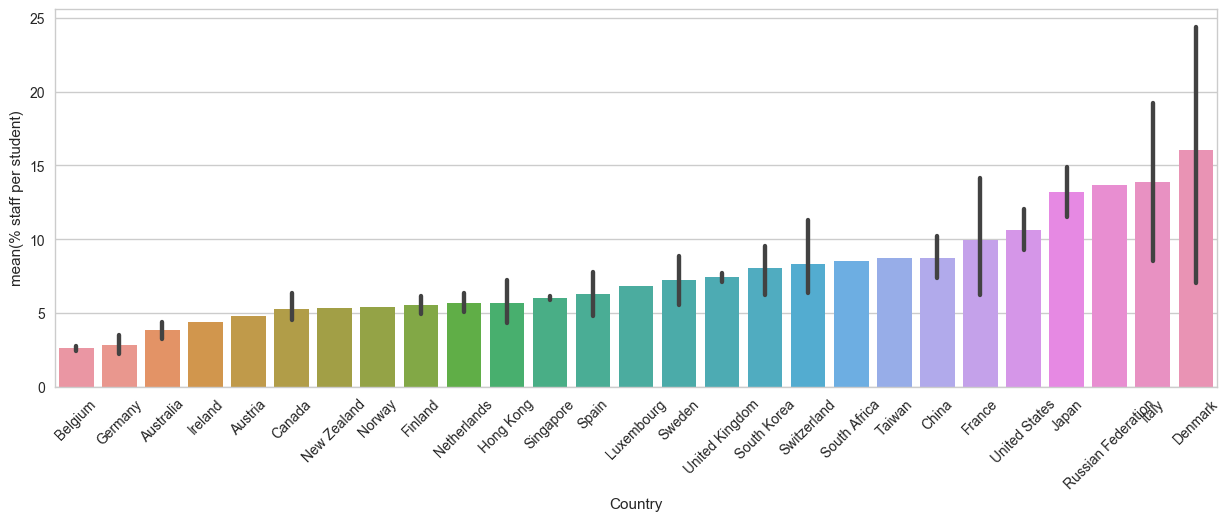

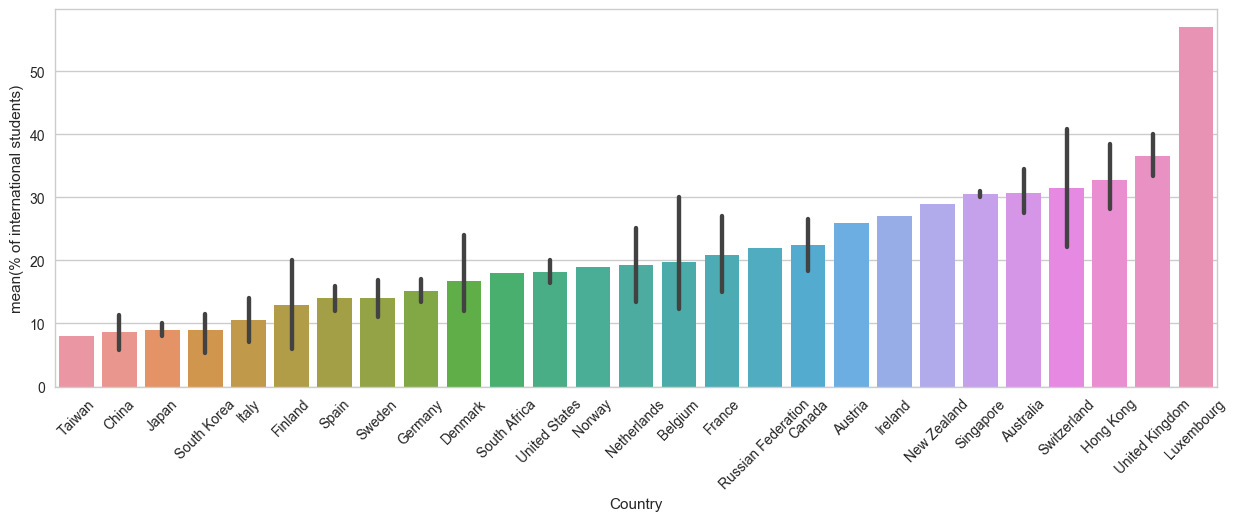

In [143]:
# Group by per country
# Percentage of staff member per student
# We create an order groupby object to sort the bar plot 
sortedGroupby = times_ranking.groupby(["Country"])['% staff per student']\
                        .mean().reset_index().sort_values('% staff per student')
# plot
ax = sns.barplot(x="Country", y="% staff per student", data=times_ranking, order=sortedGroupby['Country'])
plt.xticks(rotation = 45)
plt.show()

# Percentage of international students
# We create an order groupby object to sort the bar plot 
sortedGroupby = times_ranking.groupby(["Country"])['% of international students'].mean()\
                        .reset_index().sort_values('% of international students')
ax = sns.barplot(x="Country", y="% of international students", data=times_ranking,order=sortedGroupby['Country'])
plt.xticks(rotation = 45)
plt.show()

If we do not take into account the university in Luxembourg as there is only one in the ranking and it's not very representative, we can make the same conclusions than for the *Top Universities* ranking, 5 countries have a higher percentage of international students than the other : The United Kingdom, Switzerland, Australia, Singapore, Hong Kong. These five countries have either a low population, or a high attractivity due to the national language (UK) and exchange possibilities (ERASMUS program).

<a id = "Q2DC"></a>
## Data Correlation

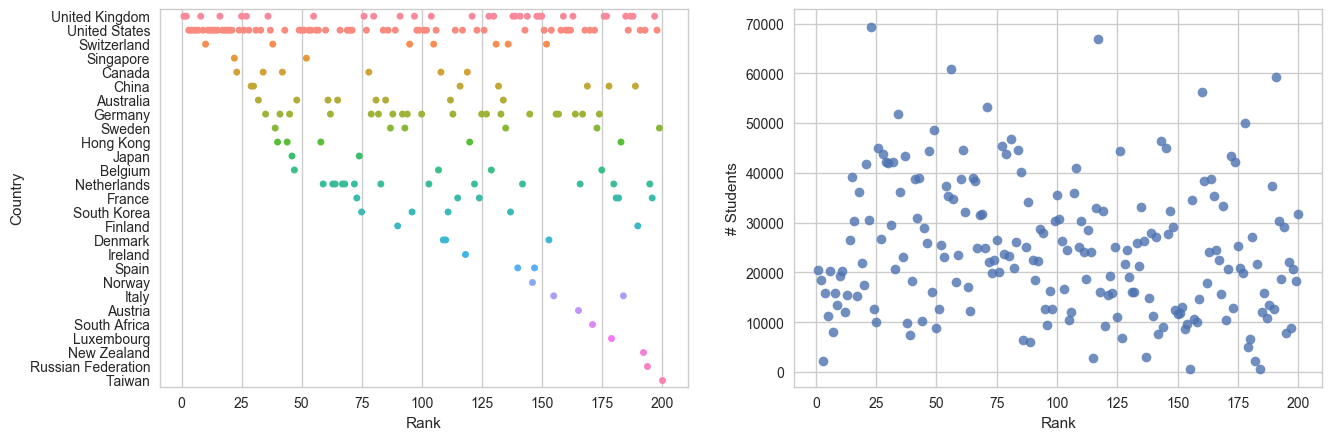

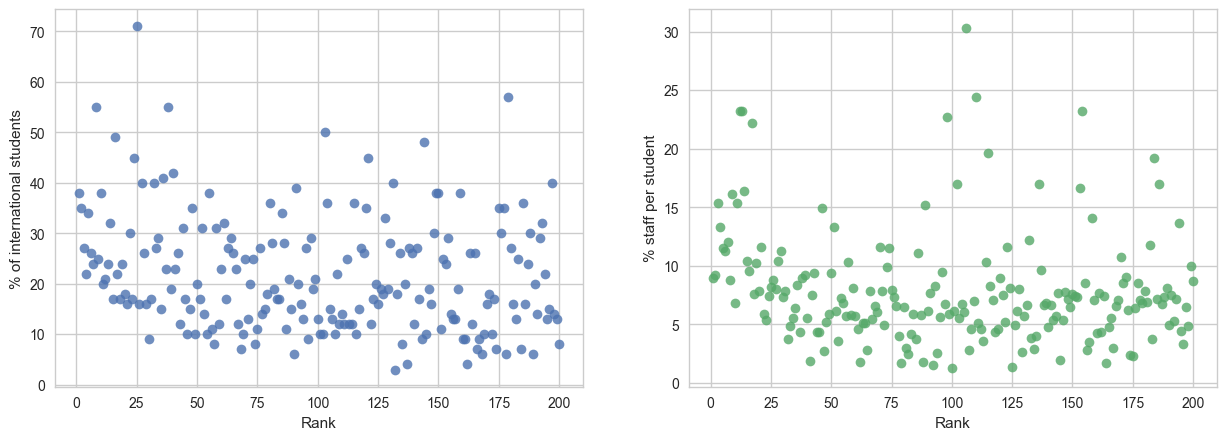

In [144]:
fig, (ax1, ax2) = plt.subplots(ncols=2)
sns.stripplot(x="Rank", y="Country", data=times_ranking, ax=ax1)
sns.regplot(x = 'Rank', y = '# Students', data=times_ranking, fit_reg=False, ax=ax2)
plt.show()
fig, (ax1, ax2) = plt.subplots(ncols=2)
sns.regplot(x = 'Rank', y = '% of international students', data=times_ranking, fit_reg=False, ax=ax1)
sns.regplot(x = 'Rank', y = '% staff per student', data=times_ranking, fit_reg=False, ax=ax2)
plt.show()

As for the previous ranking, the US universities are very present in the top 200.

For this ranking, there doesn't seem to be an explicit correlation between the rank and the multiple attributes of the dataframe.

<a id = "Q3"></a>
# Question 3.
Merge the two DataFrames created in questions 1 and 2 using university names. Match universities' names as well as you can, and explain your strategy. Keep track of the original position in both rankings.

### Answer :

<a id = "Q3NM"></a>
## Name Matching

To merge the dataframes, we need to ensure that the names of the universities in both dataframes match if they refer to the same university. To do this, we first take a look at the names of the two dataframes :

In [145]:
qs_df['Name'].head()

0    Massachusetts Institute of Technology (MIT) 
1                             Stanford University
2                              Harvard University
3    California Institute of Technology (Caltech)
4                         University of Cambridge
Name: Name, dtype: object

In [146]:
times_ranking['Name'].head()

0                     University of Oxford
1                  University of Cambridge
2       California Institute of Technology
3                      Stanford University
4    Massachusetts Institute of Technology
Name: Name, dtype: object

We notice that in the first dataframe, the initials of the university are sometimes added at the end of the Name, which is not the case in the second dataframe. We also notice that the names contains upper case and lower case caracter, and potentialy accents. To make sure that the name match between the dataframes, we will happened a column to each containing the formated names of the university : names without initials, upper case, accents ...

In [147]:
%%capture
# ^ discard output of this cell

# Create new column in each dataframe with containing the university names in lower case
qs_df['formated Name'] = qs_df['Name'].str.lower()
times_ranking['formated Name'] = times_ranking['Name'].str.lower()

# Remove the initials in parenthesis
qs_df['formated Name'] = [re.sub("[\(\[].*?[\)\]]", "", x) for x in qs_df['formated Name']]
times_ranking['formated Name'] = [re.sub("[\(\[].*?[\)\]]", "", x) for x in times_ranking['formated Name']]

# Remove the "the" before the university name
qs_df['formated Name'] = [re.sub("^(the)\s+", "", x) for x in qs_df['formated Name']]
times_ranking['formated Name'] = [re.sub("^(the)\s+", "", x) for x in times_ranking['formated Name']]

# Remove the whitespaces
qs_df['formated Name'] = [re.sub(r'\s+', '', x) for x in qs_df['formated Name']]
times_ranking['formated Name'] = [re.sub(r'\s+', '', x) for x in times_ranking['formated Name']]

# Remove the '-'
qs_df['formated Name'] = [re.sub(r'-', '', x) for x in qs_df['formated Name']]
times_ranking['formated Name'] = [re.sub(r'-', '', x) for x in times_ranking['formated Name']]

# Remove the ''
qs_df['formated Name'] = [re.sub(r"'", '', x) for x in qs_df['formated Name']]
times_ranking['formated Name'] = [re.sub(r"'", '', x) for x in times_ranking['formated Name']]

# Remove the special caracters and accents
qs_df['formated Name'] = qs_df['formated Name'].str.normalize('NFKD')\
                                               .str.encode('ascii', errors='ignore')\
                                               .str.decode('utf-8')
times_ranking['formated Name'] = times_ranking['formated Name'].str.normalize('NFKD')\
                                                               .str.encode('ascii', errors='ignore')\
                                                               .str.decode('utf-8')

In [148]:
def merge_columns_by_mean(df,column, nameleft, nameright):
    """ Merges columns of the dataframe by averaging between two othercolumns
        
        The data is merged if the indicator column value is 'both'
        Otherwise, available value is usued
        If data is not numeric, assume that columns matches perfectly and only take left values 
        column is the name of the merged columns
        nameleft is the name of one column to merge
        nameright is the name of the other column to merge """
    
    combined_df[column] = ''
    if (isinstance(df[nameleft][0], numbers.Number)):
        df.loc[df['Indicator'] == 'both', column] = \
            np.mean([df.loc[df['Indicator'] == 'both', nameleft],
                     df.loc[df['Indicator'] == 'both', nameright]], axis = 0)
        df.loc[df['Indicator'] == 'left_only', column] = \
            df.loc[df['Indicator'] == 'left_only', nameleft]
        df.loc[df['Indicator'] == 'right_only', column] = \
            df.loc[df['Indicator'] == 'right_only', nameright]
        df[column] = df[column].apply(pd.to_numeric)
    else :
        df.loc[df['Indicator'] == 'both', column] = df.loc[df['Indicator'] == 'both', nameleft]
        df.loc[df['Indicator'] == 'left_only', column] = df.loc[df['Indicator'] == 'left_only', nameleft]
        df.loc[df['Indicator'] == 'right_only', column] = df.loc[df['Indicator'] == 'right_only', nameright]
        
    df.drop([nameleft, nameright], axis = 1, inplace=True)

<a id = "Q3RM"></a>
## Region Matching

The first site (topUniversities) provided us with a Region attribute, which is not the case for the second one. In order to solve this problem we create a dictionnary with the country as the key and it's corresponding region as value

In [149]:
dict_regions = dict(zip(qs_df.Country,qs_df.Region))

times_r = [dict_regions[x] for x in times_ranking['Country'] if x in list(dict_regions.keys())]

#We set the value 'TBD' which means to be defined if a new country appears.
times_r = [dict_regions[x] if x in list(dict_regions.keys()) else 'TBD' for x in times_ranking['Country'] ]


In [150]:
#We get the index of the new countries (this ones that doesnt have any regions)
ind = [i for i,x in enumerate(times_r) if x == 'TBD']
ind

[178, 193]

In [151]:
#After inspection of the dataframe, this is the entries number 178 and 193, corresponding to Luxembourg and Russia,
#We set both their region to Europe
times_r[178] = 'Europe'
times_r[193] = 'Europe'

times_ranking['Region'] = times_r

In [152]:
#Let's have a look at the head
times_ranking.head(3)

,Rank,Name,# Students,Student per staff,% of international students,Country,% staff per student,formated Name,Region
0,1,University of Oxford,20409,11.2,38,United Kingdom,8.928571,universityofoxford,Europe
1,2,University of Cambridge,18389,10.9,35,United Kingdom,9.174312,universityofcambridge,Europe
2,3,California Institute of Technology,2209,6.5,27,United States,15.384615,californiainstituteoftechnology,North America


<a id = "Q3MERGE"></a>
## Merging of the Rankings

In [153]:
# Merging the dataframes
combined_df = pd.merge(qs_df, times_ranking,
                       how='outer', on='formated Name',
                       left_on=None, right_on=None,
                       left_index=False, right_index=False, sort=False,
                       suffixes=('_topUni', '_times'), copy=True, indicator='Indicator')

# Drop the column of formated names
combined_df.drop('formated Name', axis=1, inplace = True)

# Merge the names into only 1 column. The name of Top university is prefered if both are available
merge_columns_by_mean(combined_df, 'Name', 'Name_topUni', 'Name_times')

# Put Name as the first column
col_names = list(combined_df.columns.values)
col_names.remove('Name')
col_names.insert(0, 'Name')
combined_df = combined_df[col_names]

#let's have a look at the head
combined_df.head()

,Name,Rank_topUni,# Students_topUni,# international students,# international staff,# staff,Country_topUni,Region_topUni,% staff per student_topUni,% of international students_topUni,% of international staff,Rank_times,# Students_times,Student per staff,% of international students_times,Country_times,% staff per student_times,Region_times,Indicator
0,Massachusetts Institute of Technology (MIT),1.0,11067.0,3717.0,1679.0,2982.0,United States,North America,26.944972,33.586338,56.304494,5.0,11177.0,8.7,34.0,United States,11.494253,North America,both
1,Stanford University,2.0,15878.0,3611.0,2042.0,4285.0,United States,North America,26.987026,22.742159,47.654609,4.0,15845.0,7.5,22.0,United States,13.333333,North America,both
2,Harvard University,3.0,22429.0,5266.0,1311.0,4350.0,United States,North America,19.394534,23.478532,30.137931,6.0,20326.0,8.9,26.0,United States,11.235955,North America,both
3,California Institute of Technology (Caltech),4.0,2255.0,647.0,350.0,953.0,United States,North America,42.261641,28.691796,36.726128,3.0,2209.0,6.5,27.0,United States,15.384615,North America,both
4,University of Cambridge,5.0,18770.0,6699.0,2278.0,5490.0,United Kingdom,Europe,29.248801,35.689931,41.493625,2.0,18389.0,10.9,35.0,United Kingdom,9.174312,Europe,both


In [154]:
merged_number = combined_df[combined_df['Indicator'] == 'both'].Name.count()
print('Number of automatically merged universities : ' + str(merged_number))

Number of automatically merged universities : 141


With our algorithm, we succeeded in matching 141 universities between the two rankings. One difficulty of the matching is for university where the name is given in two different language between the rankings (e.g : *Freie Universitaet Berlin* and *Free University of Berlin*)

<a id = "Q4"></a>
# Question 4.
Find useful insights in the data by performing an exploratory analysis. Can you find a strong correlation between any pair of variables in the dataset you just created? Example: when a university is strong in its international dimension, can you observe a consistency both for students and faculty members?

### Answer

<a id = "Q4PREP"></a>
## Merging Similar Columns

Some universities appear in both rankings. For these university, the two websites provide similar information for the percentage of international students, percentage of staff members per student and number of student. If these information do match, then we can merge the corresponding columns in the dataframe, which will make the analysis easier.

In [155]:
df_both = combined_df[combined_df['Indicator'] == 'both']

To verify that the information matches, we can look at the following graphs :

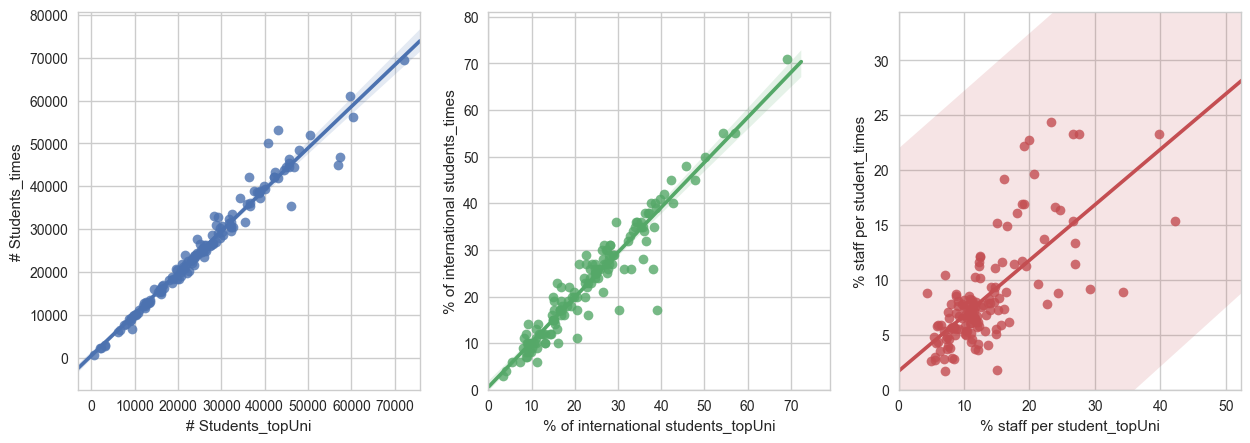

In [156]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3)
sns.regplot(x = '# Students_topUni', y = '# Students_times', data=df_both, fit_reg=True, ax=ax1)
sns.regplot(x = '% of international students_topUni', y = '% of international students_times',
            data=df_both, fit_reg=True, ax=ax2)
sns.regplot(x = '% staff per student_topUni', y = '% staff per student_times',
            data=df_both, fit_reg=True, ax=ax3)
ax2.set_xlim([0,np.max(df_both['% of international students_topUni'])+10])
ax2.set_ylim([0,np.max(df_both['% of international students_times'])+10])
ax3.set_xlim([0,np.max(df_both['% staff per student_topUni']+10)])
ax3.set_ylim([0,np.max(df_both['% staff per student_times'])+10])
plt.show()

The difference in the number of students and international students can be explained by multiple factors. For example the date where the data was collected may differ between the ranking and influence the number of students counted. Moreover a difference in methodology can also account for the difference. All in one, the differences between the two rankings for the number of students and international students are minimal for a majority of university. So we chose to merge these two columns by taking their mean.

The percentage of staff per students is clearly not correlated enough between the two rankings to merge them by taking the mean, the two entities clearly have a different methodology when computing this value.

We proceed to merge the columns that contain redundant information :

In [157]:
merge_columns_by_mean(combined_df, '# Students', '# Students_topUni', '# Students_times')
merge_columns_by_mean(combined_df, '% of international students',
                      '% of international students_topUni', '% of international students_times')
merge_columns_by_mean(combined_df, 'Country', 'Country_topUni', 'Country_times')
merge_columns_by_mean(combined_df,'Region','Region_topUni', 'Region_times')

combined_df.head(3)

,Name,Rank_topUni,# international students,# international staff,# staff,% staff per student_topUni,% of international staff,Rank_times,Student per staff,% staff per student_times,Indicator,# Students,% of international students,Country,Region
0,Massachusetts Institute of Technology (MIT),1.0,3717.0,1679.0,2982.0,26.944972,56.304494,5.0,8.7,11.494253,both,11122.0,33.793169,United States,North America
1,Stanford University,2.0,3611.0,2042.0,4285.0,26.987026,47.654609,4.0,7.5,13.333333,both,15861.5,22.371079,United States,North America
2,Harvard University,3.0,5266.0,1311.0,4350.0,19.394534,30.137931,6.0,8.9,11.235955,both,21377.5,24.739266,United States,North America


<a id = "Q4POP"></a>
## Additional Data about Country Population

We want to get the population of the countries so we extract this information from wikipedia and create a dictionnary with every country as keys and their population as values

In [158]:
# this is the url of the wikipedia page
link = 'https://en.wikipedia.org/wiki/List_of_countries_and_dependencies_by_population'

# we send a request and parse it with Beautifulsoup
r = requests.get(link)
wrapped_hab = BeautifulSoup(r.text,'html.parser')

# Get the table of country populations
list_country = wrapped_hab.find_all('table', {'class': 'wikitable sortable'})[0].children
hab_country = {}
country=[]
pop = []

# We create two lists to store the country name and population
for l in list(list_country)[2:]:
    if 'find_all' in l.__dir__():
        pop_li = l.find_all('td')
        count_li = l.find_all('a')
        
        pop_li = [x.text.replace(',', '') for x in pop_li if x.text.replace(',', '').isnumeric()]
        hab = pop_li[1] if len(pop_li) > 1 else pop_li[0]
        pop.append(hab)
        
        count_li = [x for x in count_li if ('wiki' in x['href'].split('/')) and ('File' not in x['href'].split('/')[2])]
        title = count_li[0]['title']
        country.append(title)
        
hab_country = dict(zip(country, pop))

In [159]:
#In our data frame we have "Republic of Ireland" and in the wikipedia data we have "Ireland" so we manually fix this.
hab_country['Ireland'] = hab_country['Republic of Ireland']

In [160]:
#Now we create a column with the population of the countries.
population = [hab_country[x] for x in combined_df['Country']]
combined_df['population of country'] = population
combined_df['population of country'] = pd.to_numeric(combined_df['population of country'])

#Again we check the head of our combined data frame.
combined_df[['Name','population of country']].head()

,Name,population of country
0,Massachusetts Institute of Technology (MIT),325992000
1,Stanford University,325992000
2,Harvard University,325992000
3,California Institute of Technology (Caltech),325992000
4,University of Cambridge,65648000


<a id = "Q4DC"></a>
## Data Correlation

To find correlation in the data, we plot the heatmap of the correlation matrix of the dataframe :

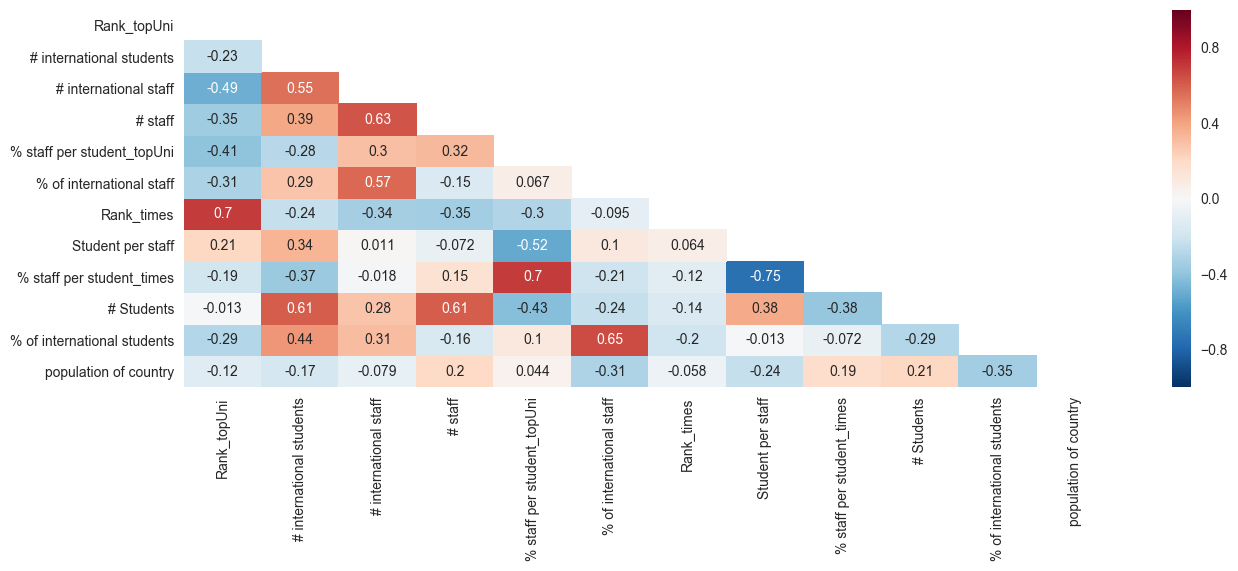

In [161]:
# We fisrt compute the correlation matrix
corrmat = combined_df[combined_df['Indicator'] == 'both'].dropna().corr()
# We construct a mask to get only the lower triangular part of the correlation matrix, because it's symmetric
mask = np.zeros_like(corrmat, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
# We then plot the heatmap of the correlation matrix with the mask
plot = sns.heatmap(corrmat,mask = mask, annot=True)

We observe a number of interesting correlation value for different attributes, we will now detail them :

- We observe that the two ranking have a correlation of 0.7, even if they have a different methodology their rankings are similar. 
- The number of faculty staff and the number of international students is correlated to the number of students with a correlation of around 0.6. It is to be expected, the more students you have, the higher number of faculty staff you need. And the higher number of students you have, the higher the chance that one is an international one.

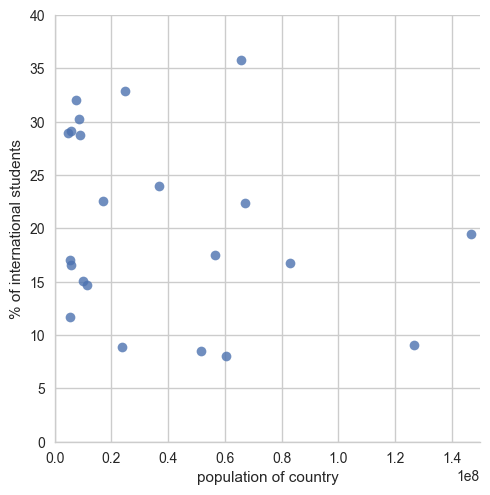

In [162]:
dfGroupbyCountry = combined_df[combined_df['Indicator'] == 'both'].dropna().groupby("Country").mean()
# Plot of the average percentage of international student relatively to the population of the country
sns.lmplot(x = 'population of country',
           y = '% of international students',
           data=dfGroupbyCountry,
           fit_reg = False)

# We change the axis to focus on the smallest countries
ax = plt.gca()
ax.set_xlim([0.0, 0.15e9])
ax.set_ylim([0.0, 40])
plt.show()

There is a small cluster of high international student percentages for countries with small population (less than 20 millions) as we have seen previously.

<a id = "Q5"></a>
# Question  5.
Can you find the best university taking in consideration both rankings? Explain your approach.

### Answer

Before computing the best university, let's take a look at the methodology used in both ranking :

#### [Top Universities methodology](https://www.topuniversities.com/qs-world-university-rankings/methodology)

The ranking comes from a ponderation of 6 different parameters : The Academic Reputation (40%), The Employer Reputation (10%), The Faculty/Student Ratio (20%), Citation per Faculty (20%), International faculty ratio (5%), International Student ratio (5%)


#### [Times Higher Education methodology](https://www.timeshighereducation.com/world-university-rankings/methodology-world-university-rankings-2018)

The ranking is computed using these attributes : The Learning Environment (30%), The Research Excellence (30%), The Research Influence (30%), The International Outlook (7.5%), The Industry Income (2.5%)


The Top Universities ranking put a higher weight on the general reputation of the university (40%) while the Times Higher Education ranking put a lot of weight on the research reputation (60%) of the university. 

To find the best university we decided to put more weight to more objective/quantifiable attributes. The Times Higher Education ranking methodology seems to give slightly more weight to these types of attributes than the Top Universities ranking. So we chose to give a weight of 0.6 to the Times Higher Education ranking, and 0.4 to the Top Universities one. Moreover, we decided to give more weight to the ratio Faculty Staff/Student as we thought that it is an important factor to decide the quality of the education. We give the old ranking a weight of 0.8 and the ratio a weight of 0.2.

We get the following formula to compute the new rank :

#### New Rank = 0.8\*(0.6\*Rank_Times + 0.4\*Rank_TopUni) + 0.2\*Rank_Staff/Student

Where Rank_Staff/Student is the position of university in a dataframe ordered by the ratio staff/student.

In [163]:
### Get a dataframe with no NaN (Matching names where found in the two rankings)
df_both = combined_df[combined_df['Indicator'] == 'both']

### Sort the percentage of staff per student by decreasing order
df_both = df_both.sort_values('% staff per student_times',ascending = False)
### Create a new Ranking column that ranks the ratio of staff per student
df_both['Rank_Staff/Student'] = np.linspace(1,df_both.Name.count(),df_both.Name.count())

In [164]:
### Compute the new rank
df_both['New Rank'] = 0.8*(0.6*df_both['Rank_times'] + 0.4*df_both['Rank_topUni']) + 0.2*df_both['Rank_Staff/Student']

In [165]:
### Sort the dataframe by the new rank and transform it into increasing integer
df_both = df_both.sort_values('New Rank')
df_both['New Rank'] = np.linspace(1,df_both.Name.count(),df_both.Name.count())
### Set the new rank as index for the dataframe
df_both = df_both.set_index('New Rank')

In [166]:
df_both.head(1)

,Name,Rank_topUni,# international students,# international staff,# staff,% staff per student_topUni,% of international staff,Rank_times,Student per staff,% staff per student_times,Indicator,# Students,% of international students,Country,Region,population of country,Rank_Staff/Student
New Rank,,,,,,,,,,,,,,,,,
1.0,California Institute of Technology (Caltech),4.0,647.0,350.0,953.0,42.261641,36.726128,3.0,6.5,15.384615,both,2232.0,27.845898,United States,North America,325992000,15.0


We had the choice to take the ratio of staff per student from the Times Higher Education Ranking or from the Top Universities ranking, however with both value the first university stays the same : **California Institute of Technology (Caltech)**

<a id = "EXTRA"></a>
# Extra : World Map Visualization

This section of the notebook requires specific libraries to display the maps. The corresponding imports are commented at the start of the notebook, but the libraries need to be installed by the user.

The maps use additional information about the country that are stored in external files. These files are available in this git repository : [country data](https://gitlab.com/4p0pt0Z/CountryMapDataADAHomework2) . These information are available at [Global Administrative Area](http://www.gadm.org) and free to use for academic purposes. There are not provided in the homework repository as they occupy approximately 1 Go of storage space. Also to save space and computational time, we only plot the first 15 countries with the highest number of universities in the ranking.

### Top Universities website ranking

In [68]:
#First we want to create a map for (qs ranking):
#nb countries who got the more universities.

nb = 15

#The number of universities per country
uni_count = qs_df['Country'].value_counts()[:15]
#List of all countries
countries = list(uni_count.keys())

#We chose to separate the 15 countries into 4 categories and to represent them we chose this 4 colors.
colors = ['red','orange','yellow','green']

#This is the threshold of the categories
steps = [47,28,12,7]


#We create a dictionnary 'colors_f' with the country as key and it's corresponding color as value
colors_f = {}
dict_colors = dict(zip(steps, colors))

#For every country, we check the number of universities within and we set the colors in function of the thresholds defined
#in 'steps
for i in range(len(countries)):
    for j in range(len(steps)):
        if(uni_count[i] <= steps[j]):
            colors_f[countries[i]] = dict_colors[steps[j]]
            
#Let's look at the results            
#colors_f

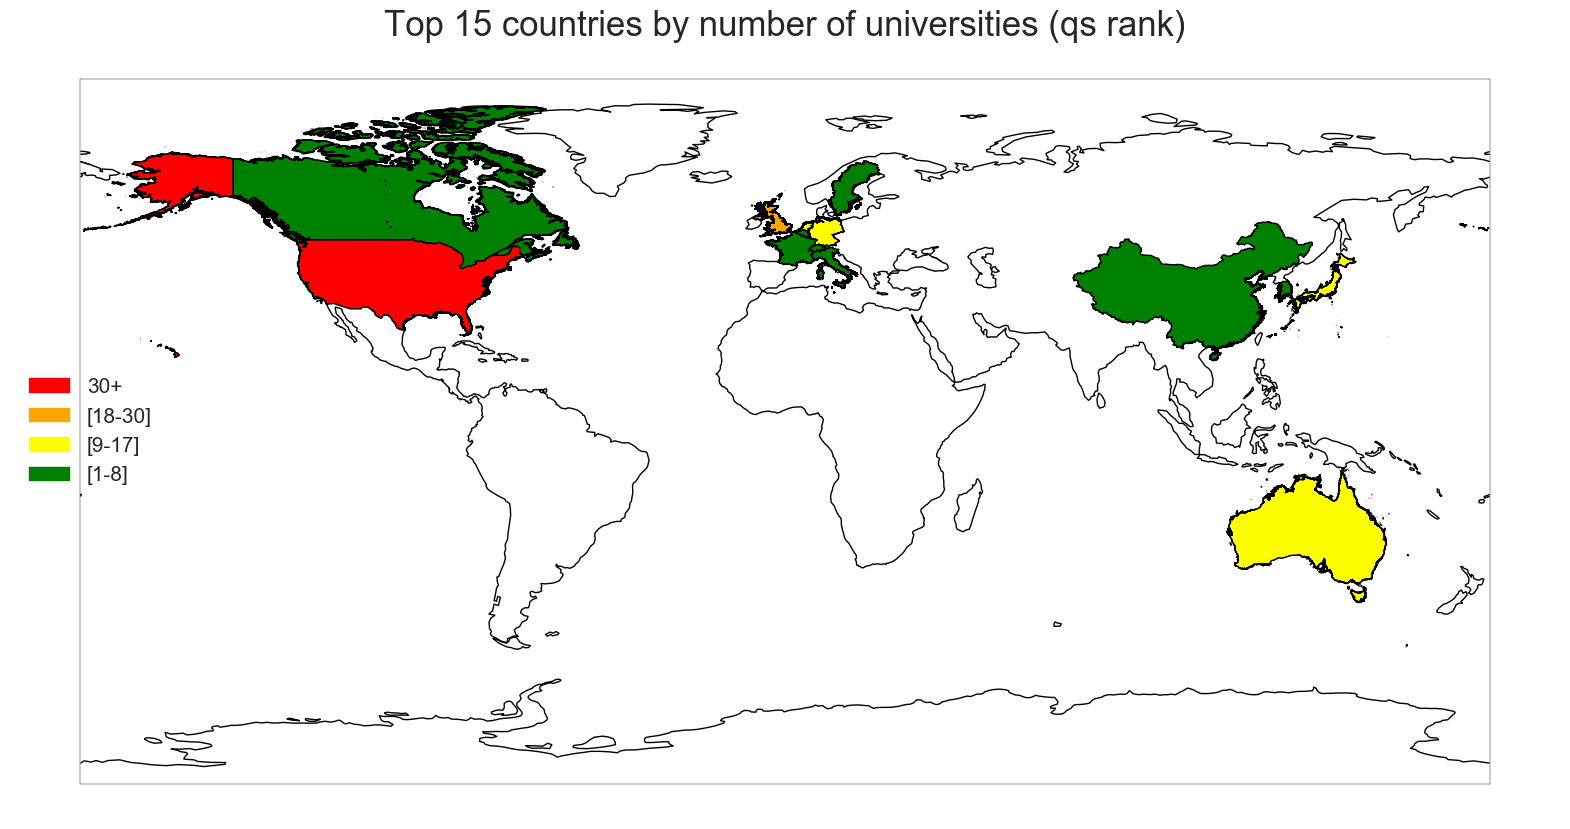

In [69]:
#Let's now create the map, we use an extra library : cartopy. To fill, with different colors, every country we need the 
#corresponding localisation of it and to get it we download shapefiles from :'http://www.gadm.org/'.

#We define the size of the map here
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 20
fig_size[1] = 16
plt.rcParams["figure.figsize"] = fig_size

#We define the map here, with a PlateCarree projection
ax = plt.axes(projection=ccrs.PlateCarree())

#We draw the borders of the regions (the coast lines)
ax.coastlines()

#Each shapefile are in a folder named 'countries' so we start the path with 'countries/'
name_st = 'countries/'

#Each shapefile information end with '.shp'
end_st = '.shp'

for i in colors_f:
    
    #for every country we form the path (for exemple countries/Switzerland/Switzerland.shp)
    fname= name_st + str(i) +'/'+str(i) + end_st
        
    
    #We get the geometry (the informations related to the longitude/latitude) of the country 
    adm1_shapes = list(shpreader.Reader(fname).geometries())
    
    color = colors_f[i]
    
    #We fill the country geometry with the corresponding color
    ax.add_geometries(adm1_shapes, ccrs.PlateCarree(),
                 edgecolor='black', facecolor=color, alpha=1)


#Set the title
ax.set_title('Top 15 countries by number of universities (qs rank)',fontsize=25)

#Set the legends   
red_patch = mpatches.Patch(color='red', label='30+')
orange_patch = mpatches.Patch(color='orange', label='[18-30]')
yellow_patch = mpatches.Patch(color='yellow', label='[9-17]')
green_patch = mpatches.Patch(color='green', label='[1-8]')

ax.legend(handles=[red_patch, orange_patch,yellow_patch,green_patch],loc = 6,fontsize=15)

#save the image
plt.savefig("top15countrqs.png")  

#show the map
plt.show()

- We see that the United States of America is the country with the biggest number of universities in the top 200.

- Europe is well represented with a lot of countries having universities in the top 200, with United Kingdom "leading" this continent.

- Three countries represents Asia in the top, with Japan, South Korea and China.

This is the distrubution for the countries but what about the distribution by region ? 

In [70]:
#Now we want to create a second map with the number of universities per region, the method is exactly the same as the previous one.
#We define here the dictionnary of the colors and the thresholds.

#Number of universities per region
uni_reg = qs_df['Region'].value_counts()
countries = list(uni_reg.keys())
colors = ['red','orange','yellow','green']
steps = [90,54,11,1]
colors_f = {}
dict_colors = dict(zip(steps, colors))

for i in range(len(countries)):
    for j in range(len(steps)):
        if(uni_reg[i] <= steps[j]):
            colors_f[countries[i]] = dict_colors[steps[j]]

#The unique 'problem' is that in the sape file we have 'South America' and 'Latin America' in the dataframe, we 
#solve this problem by creating a new key/value in the dictionnary
colors_f['South America'] = colors_f['Latin America']
colors_f.pop('Latin America', None)

#By inspecting the dictionnary, the dataframe and the shapefile we see that Australia is considered as a region for the shapefile
#and we decide to set the color to yellow by inspecting the values.
colors_f['Australia'] = 'yellow'

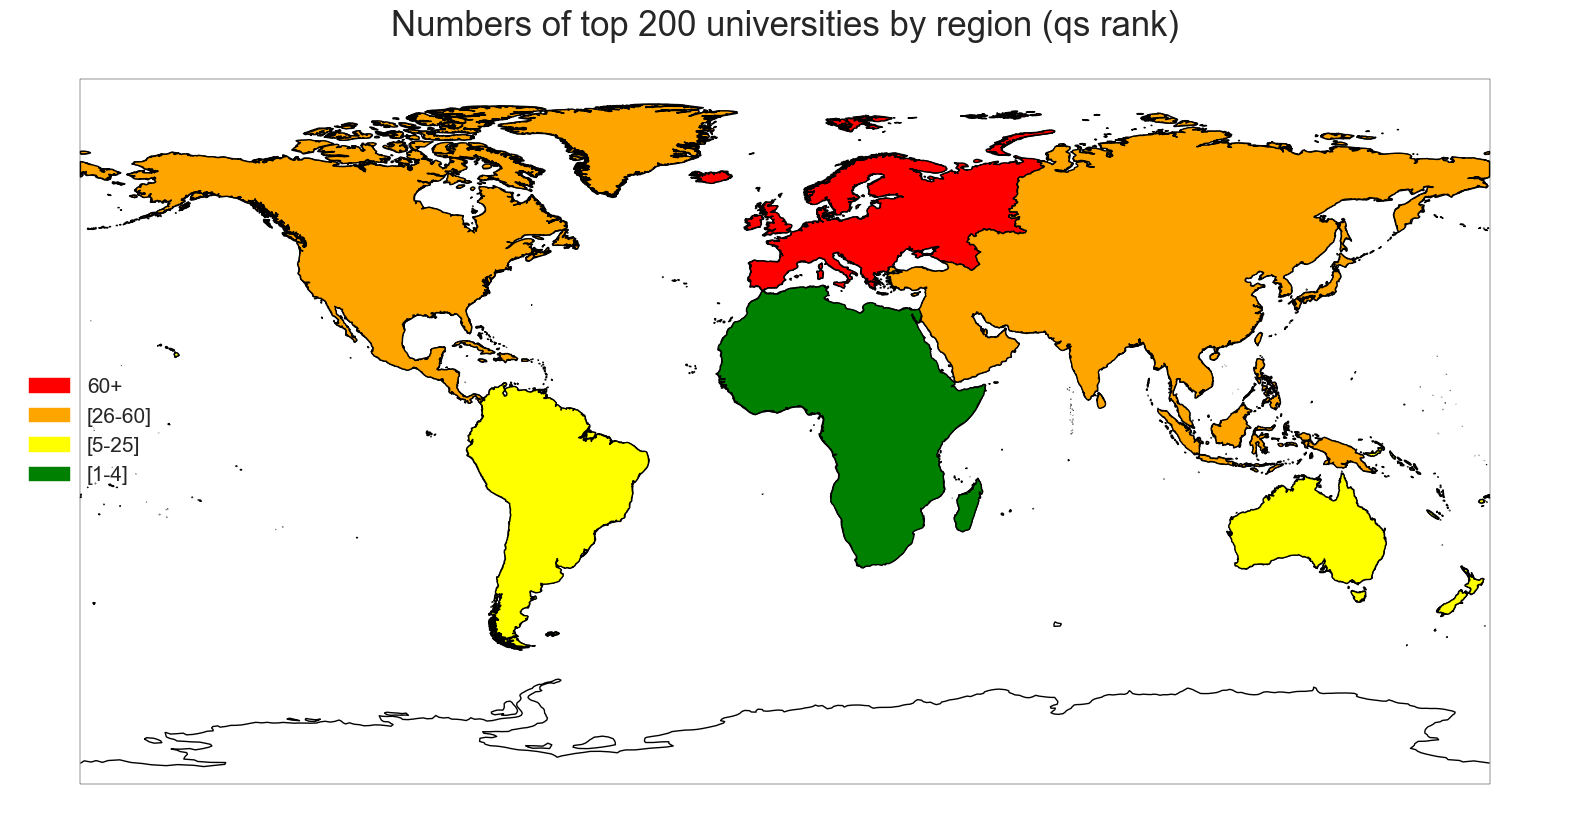

In [71]:
#Creation of the second map
#Again this is the same technique as before,

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 20
fig_size[1] = 16
plt.rcParams["figure.figsize"] = fig_size

#create the map and draw the coast lines
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()

#name of the folder
name_st = 'countries/continents/continent.shp'

for i in colors_f:
    
    fname = name_st
    
    #here the folder contains each region in a single shapefile, so we had to use some tricks to get the values we want
    adm1_shapes = list(shpreader.Reader(fname).geometries())
    adm1_records = list(shpreader.Reader(fname).records())
    
    for j in range(len(adm1_records)):
        #after inspecting the file we see that the name of the continent is in .attributes['CONTINENT]
        #We check if the continent corresponds to the current one and then we fill the continent with
        #the corresoonding color.
        if(adm1_records[j].attributes['CONTINENT'] == i):
            color = colors_f[i]
            ax.add_geometries(adm1_shapes[j], ccrs.PlateCarree(),
                 edgecolor='black', facecolor=color, alpha=1)
    
#Set the title 
ax.set_title('Numbers of top 200 universities by region (qs rank)',fontsize=25)

#Create the legends   
red_patch = mpatches.Patch(color='red', label='60+')
orange_patch = mpatches.Patch(color='orange', label='[26-60]')
yellow_patch = mpatches.Patch(color='yellow', label='[5-25]')
green_patch = mpatches.Patch(color='green', label='[1-4]')

ax.legend(handles=[red_patch, orange_patch,yellow_patch,green_patch],loc = 6,fontsize=15)

#save the image
plt.savefig("topregionsqs.png")  

#Show
plt.show()

- Europe is the leading region in term of number of universities in this ranking, North America and Asia are the following leading regions.

- We see that Africa only has few universities.

## Times website ranking

We display the same maps for the other ranking

In [73]:
#In order to get more insight about the data and visualize it easily, we decide, again to create a map with the
#15 countries who got the more universities.

a = times_ranking['Country'].value_counts()[:15]
countries = list(a.keys())
colors = ['red','orange','yellow','green']
steps = [65,35,15,10]
colors_f = {}
dict_colors = dict(zip(steps, colors))



for i in range(len(countries)):
    for j in range(len(steps)):
        if(a[i] <= steps[j]):
            colors_f[countries[i]] = dict_colors[steps[j]]
            
#colors_f

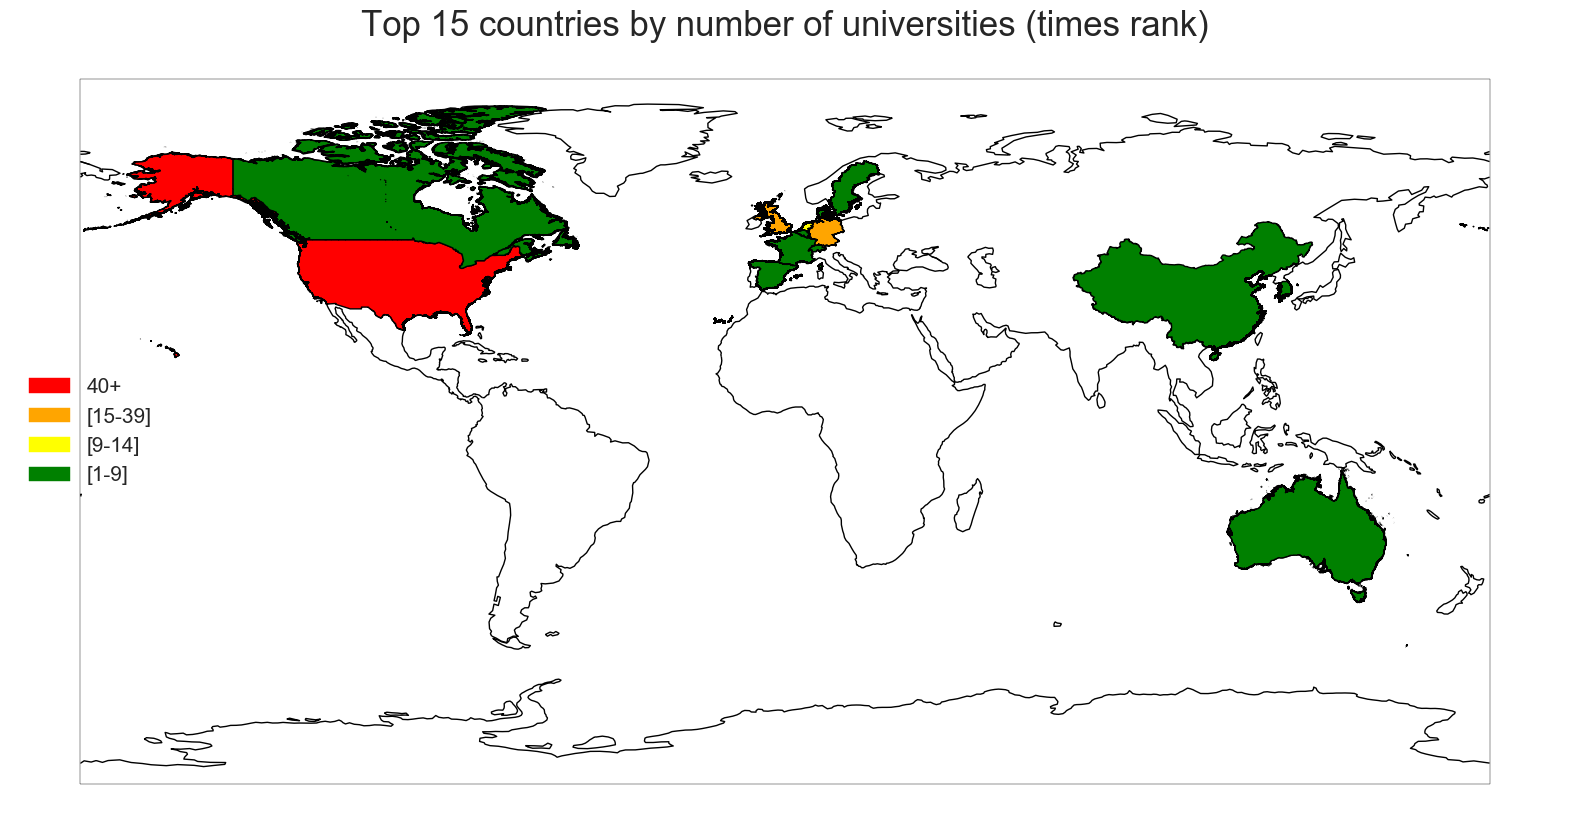

In [74]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 20
fig_size[1] = 16
plt.rcParams["figure.figsize"] = fig_size

ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()

name_st = 'countries/'
end_st = '.shp'

for i in colors_f:
    fname= name_st + str(i) +'/'+str(i) + end_st
        
    #print(fname)
    
    adm1_shapes = list(shpreader.Reader(fname).geometries())
    
    color = colors_f[i]
    
    ax.add_geometries(adm1_shapes, ccrs.PlateCarree(),
                 edgecolor='black', facecolor=color, alpha=1)


ax.set_title('Top 15 countries by number of universities (times rank)',fontsize=25)

   
red_patch = mpatches.Patch(color='red', label='40+')
orange_patch = mpatches.Patch(color='orange', label='[15-39]')
yellow_patch = mpatches.Patch(color='yellow', label='[9-14]')
green_patch = mpatches.Patch(color='green', label='[1-9]')


ax.legend(handles=[red_patch, orange_patch,yellow_patch,green_patch],loc = 6,fontsize=15)
    
plt.savefig("top15countrties.png")    
plt.show()

In [75]:
a = times_ranking['Region'].value_counts()
countries = list(a.keys())
colors = ['red','orange','yellow','green']
steps = [120,70,25,10]
colors_f = {}
dict_colors = dict(zip(steps, colors))



for i in range(len(countries)):
    for j in range(len(steps)):
        if(a[i] <= steps[j]):
            colors_f[countries[i]] = dict_colors[steps[j]]
            
colors_f['Australia'] = colors_f['Oceania']
#colors_f

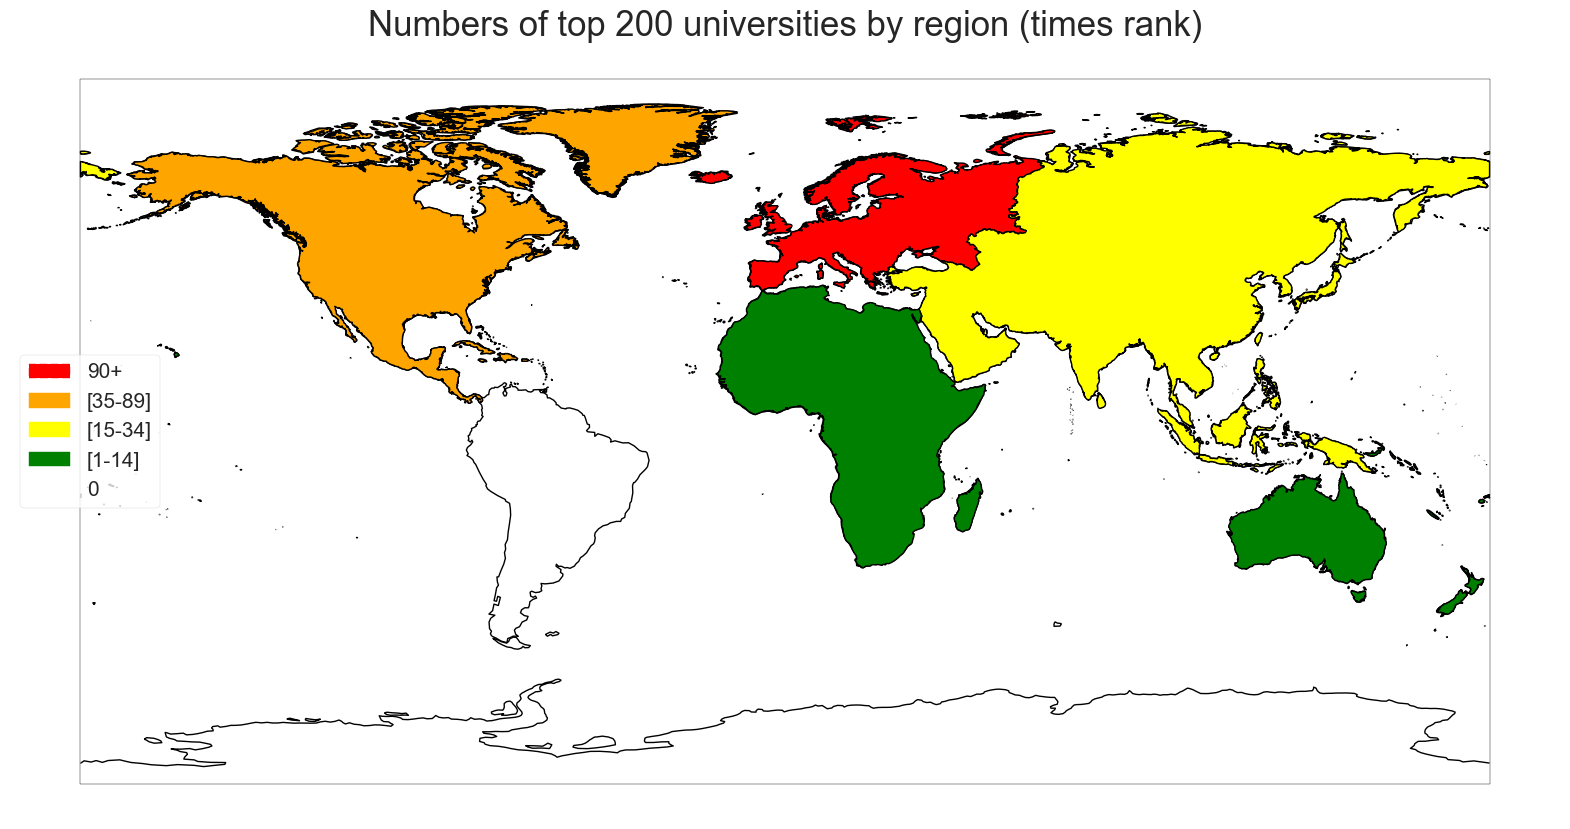

In [76]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 20
fig_size[1] = 16
plt.rcParams["figure.figsize"] = fig_size

ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()

name_st = 'countries/continents/continent.shp'
end_st = '.shp'

for i in colors_f:
    fname = name_st
        
    adm1_shapes = list(shpreader.Reader(fname).geometries())
    adm1_records = list(shpreader.Reader(fname).records())
    
    for j in range(len(adm1_records)):
        if(adm1_records[j].attributes['CONTINENT'] == i):
            color = colors_f[i]
            ax.add_geometries(adm1_shapes[j], ccrs.PlateCarree(),
                 edgecolor='black', facecolor=color, alpha=1)
    
    
ax.set_title('Numbers of top 200 universities by region (times rank)',fontsize=25)


red_patch = mpatches.Patch(color='red', label='90+', linestyle = 'dashed')
orange_patch = mpatches.Patch(color='orange', label='[35-89]')
yellow_patch = mpatches.Patch(color='yellow', label='[15-34]')
green_patch = mpatches.Patch(color='green', label='[1-14]')
white_patch = mpatches.Patch(color='white', label='0',linestyle = 'solid')


ax.legend(handles=[red_patch, orange_patch,yellow_patch,green_patch,white_patch],loc = 6,fontsize=15,frameon = True,fancybox = True)
#plt.legend(frameon=True)

    
plt.savefig("topregionstimes.png")    

plt.show()

We can see that the repartition of the universities in both rankings is very unequal, both at country level and Region level. Contrary to the Top Universities ranking, in the Times one there is no South American university in the ranking.